In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
from matplotlib.colors import LogNorm
import numpy as np

In [3]:
from analysis.beerdata_loader import BeerDataLoader

data_loader = BeerDataLoader(data_dir="../ada-2024-project-data-crusadas/data/RateBeer", force_process=False)

rb_reviews_df, rb_ratings_df, rb_beers_df, rb_breweries_df, rb_users_df = (
    data_loader.load_all_data()
)

print("Reviews DataFrame:")
print(rb_reviews_df.head())

print("\nRatings DataFrame:")
print(rb_ratings_df.head())

print("\nBeers DataFrame:")
print(rb_beers_df.head())

print("\nBreweries DataFrame:")
print(rb_breweries_df.head())

print("\nUsers DataFrame:")
print(rb_users_df.head())

Processed file '../ada-2024-project-data-crusadas/data/RateBeer\reviews_processed.csv' already exists. Skipping processing.
Processed file '../ada-2024-project-data-crusadas/data/RateBeer\ratings_processed.csv' already exists. Skipping processing.
Reviews DataFrame:
             beer_name  beer_id brewery_name  brewery_id       style  abv  \
0    33 Export (Gabon)   410549      Sobraga        3198  Pale Lager  5.0   
1  Castel Beer (Gabon)   105273      Sobraga        3198  Pale Lager  5.2   
2  Castel Beer (Gabon)   105273      Sobraga        3198  Pale Lager  5.2   
3  Castel Beer (Gabon)   105273      Sobraga        3198  Pale Lager  5.2   
4  Castel Beer (Gabon)   105273      Sobraga        3198  Pale Lager  5.2   

         date     user_name  user_id  appearance  aroma  palate  taste  \
0  1461664800       Manslow   175852           2      4       2      4   
1  1487329200  MAGICuenca91   442761           2      3       2      4   
2  1466762400        Sibarh   288889           3

**First question to ask: what is the ditribution of reviewers accross countries?**

             cleaned_location  nbr_ratings
160  United States of America      3274619
39                    Denmark       633814
28                     Canada       546493
159            United Kingdom       465714
143                    Sweden       305113
106               Netherlands       263071
52                    Germany       238709
113                    Norway       231676
122                    Poland       207299
49                    Finland       205541


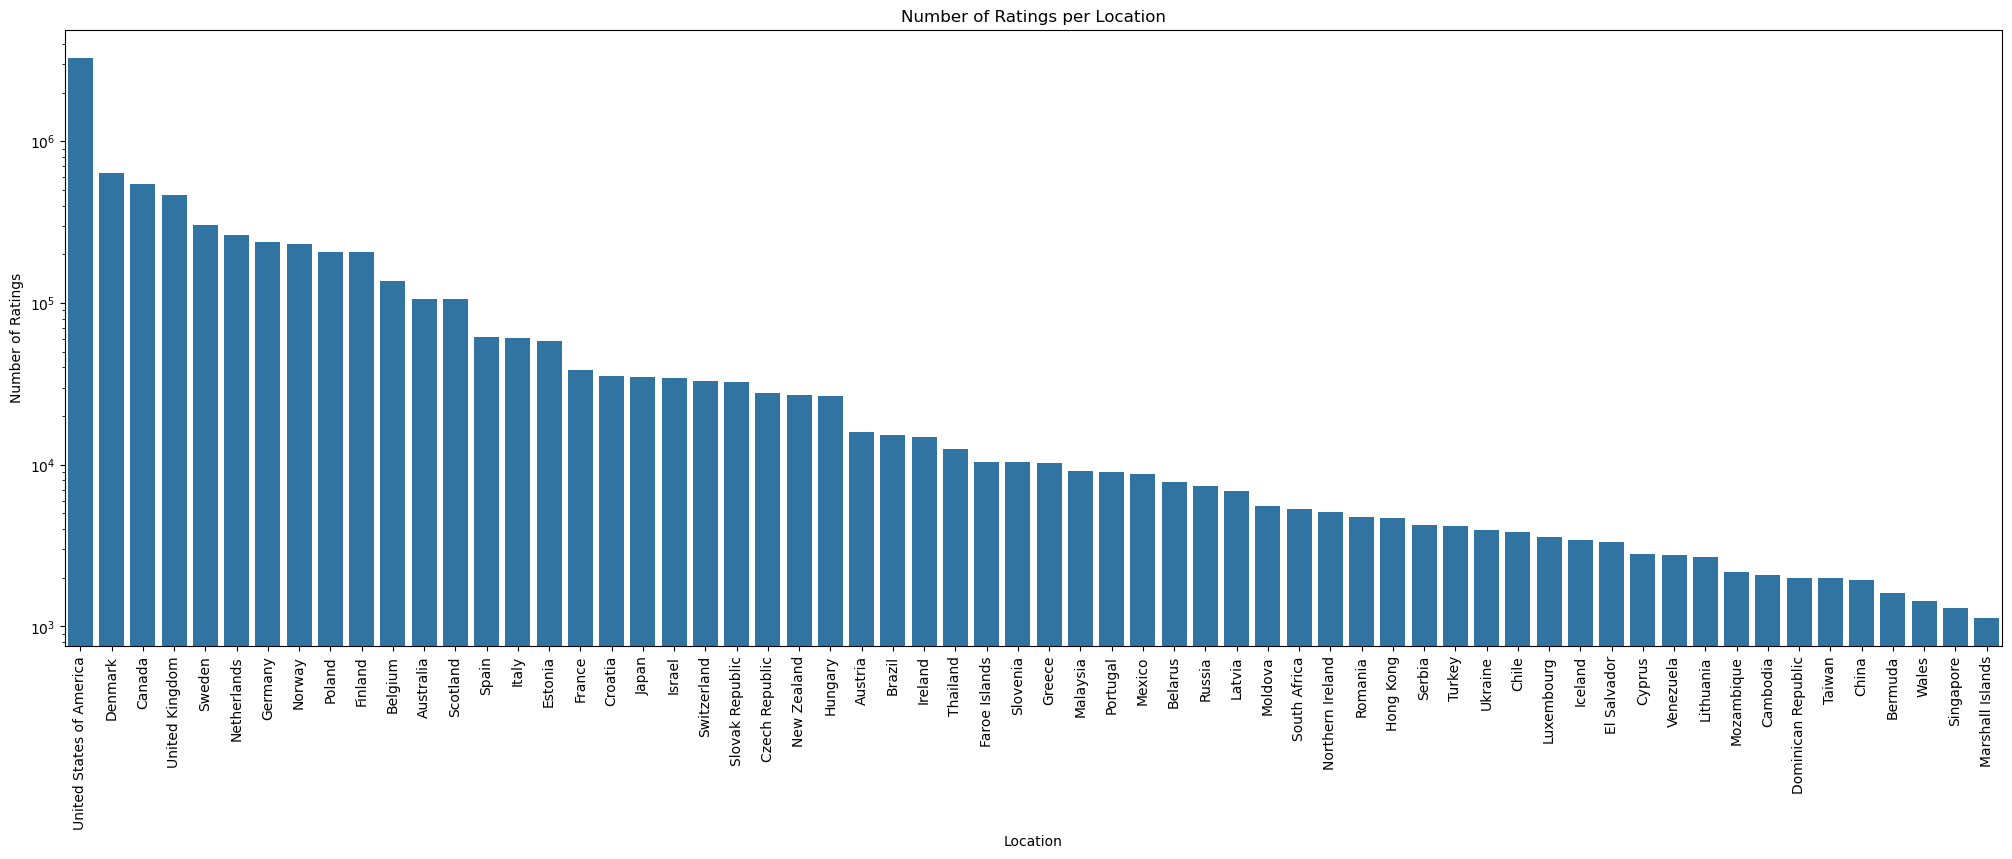

In [3]:
def clean_location(location):
    #The goal of this method is to change the name of some countries
    #to be able to use them on the shapefile
    if isinstance(location, str):  # Check if location is a string
        country = location.split(',')[0].strip()
        # Replace "United States" with "United States of America"
        if country == "United States":
            return "United States of America"
        if country == "England":
            return "United Kingdom"
        return country
    return None

# Apply the cleanup function
rb_users_df['cleaned_location'] = rb_users_df['location'].apply(clean_location)
#Compute the number of ratings per location
nbr_ratings_per_location = rb_users_df.groupby('cleaned_location')['nbr_ratings'].sum().reset_index()
#Keep only the location where there were more than 1000 ratings
nbr_ratings_per_location = nbr_ratings_per_location[nbr_ratings_per_location['nbr_ratings'] > 1000].sort_values(by='nbr_ratings', ascending=False)

print(nbr_ratings_per_location.head(10))
plt.figure(figsize=(25, 8))
sns.barplot(data=nbr_ratings_per_location, x='cleaned_location', y='nbr_ratings', log=True)
plt.title('Number of Ratings per Location')
plt.xlabel('Location')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)  # Rotate location names vertically
plt.show()

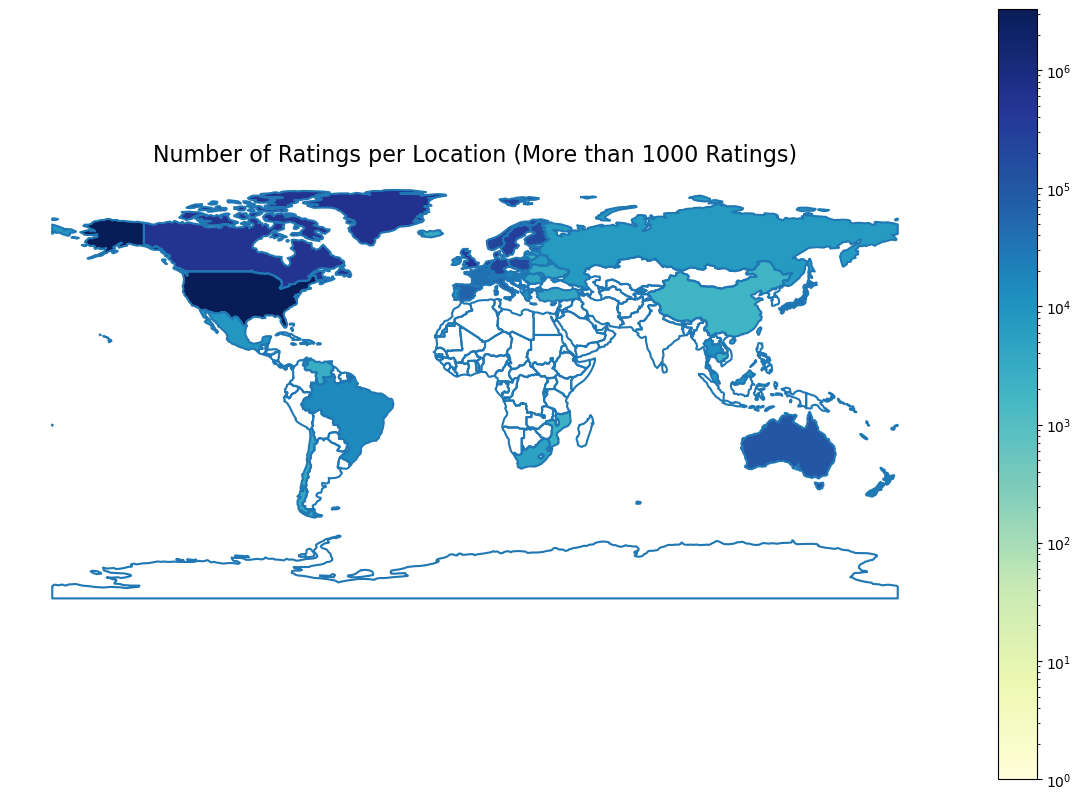

In [4]:
shapefile_path = r'C:\Users\Qrnqult\OneDrive\Documents\GitHub\ada-2024-project-data-crusadas\ne_110m_admin_0_countries\ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)

# Merge your ratings data with the world GeoDataFrame
merged = world.merge(nbr_ratings_per_location, how='left', left_on='SOVEREIGNT', right_on='cleaned_location')

# Fill NaN values in 'nbr_ratings' with 0 for visualization
merged['nbr_ratings'] = merged['nbr_ratings'].fillna(0)

# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.boundary.plot(ax=ax)  # Plot the world boundaries
merged.plot(column='nbr_ratings', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.8', 
            norm=LogNorm(vmin=1, vmax=merged['nbr_ratings'].max()), legend=True)

# Customizing the plot
ax.set_title('Number of Ratings per Location (More than 1000 Ratings)', fontsize=16)
ax.set_axis_off()  # Turn off the axis
plt.show()

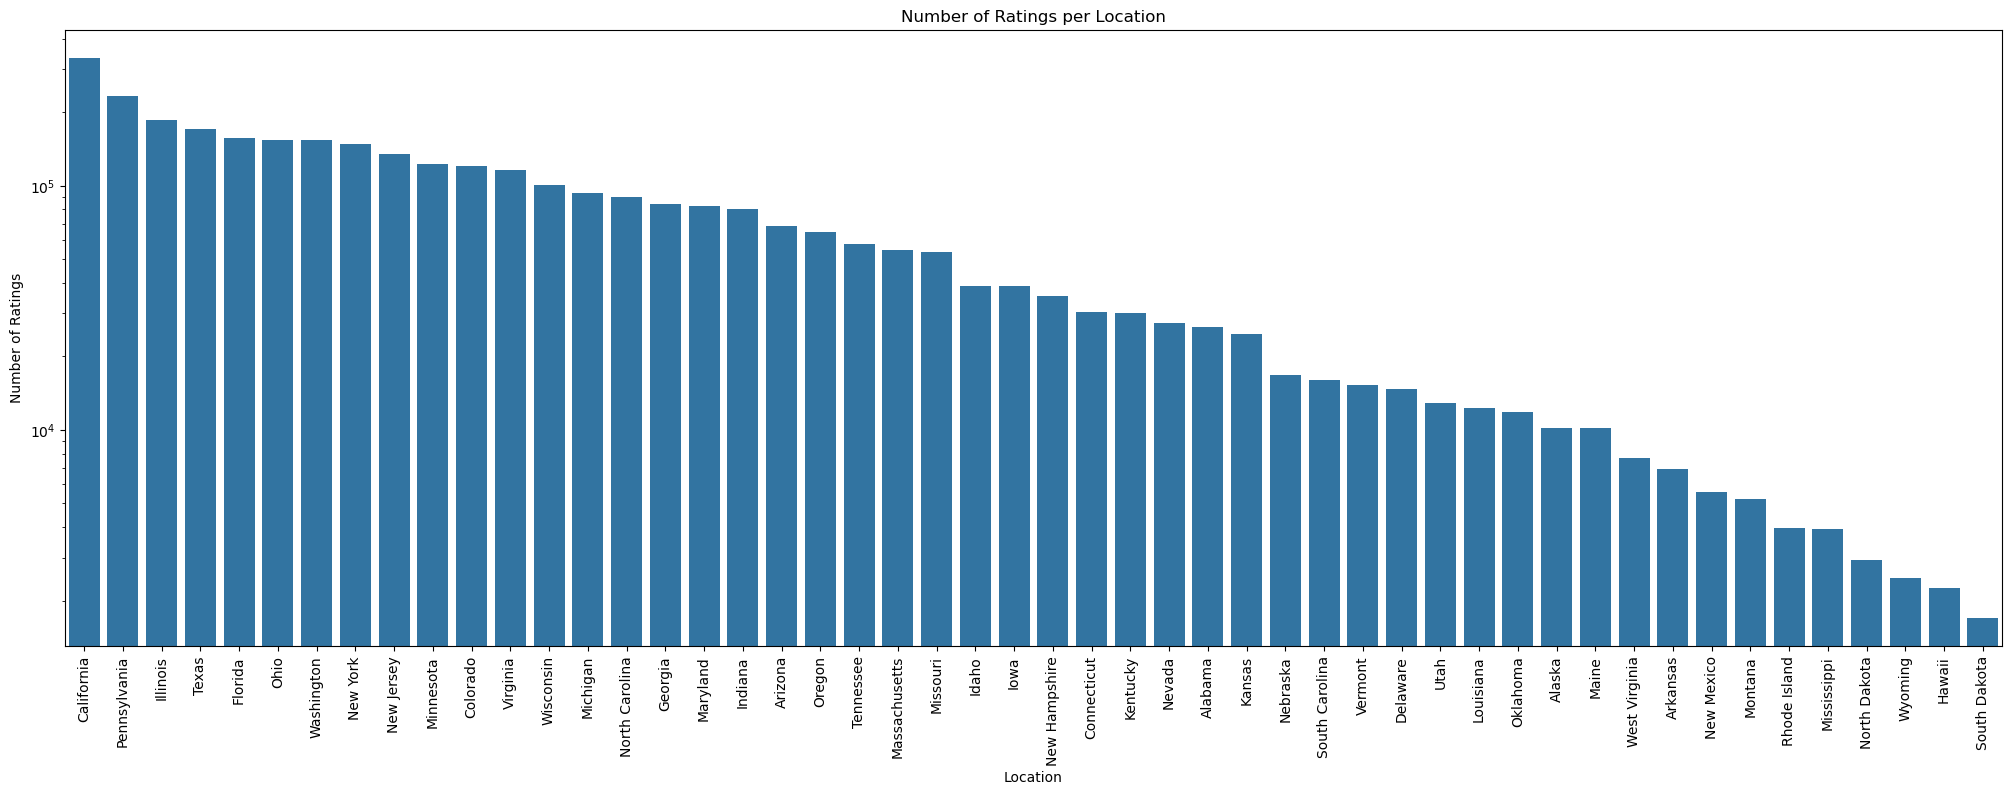

In [5]:
def clean_states(location):
    # This function will clean the location string by extracting the last part (state or city)
    if isinstance(location, str):  # Check if location is a string
        # Split the location by commas and strip whitespace
        parts = location.split(',')
        # Return the last part, which should be the state or city
        return parts[-1].strip() if parts else None
    return None

# Apply the cleanup function
us_states_df = rb_users_df[rb_users_df['location'].str.startswith("United States", na=False)].copy()
us_states_df['states'] = us_states_df['location'].apply(clean_states)
#Compute the number of ratings per location
nbr_ratings_per_location = us_states_df.groupby('states')['nbr_ratings'].sum().reset_index()
#Keep only the location where there were more than 1000 ratings
nbr_ratings_per_location = nbr_ratings_per_location[nbr_ratings_per_location['nbr_ratings'] > 200].sort_values(by='nbr_ratings', ascending=False)

plt.figure(figsize=(25, 8))
sns.barplot(data=nbr_ratings_per_location, x='states', y='nbr_ratings', log=True)
plt.title('Number of Ratings per Location')
plt.xlabel('Location')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)  # Rotate location names vertically
plt.show()

Index(['REGION', 'DIVISION', 'STATEFP', 'STATENS', 'GEOID', 'GEOIDFQ',
       'STUSPS', 'NAME', 'LSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')


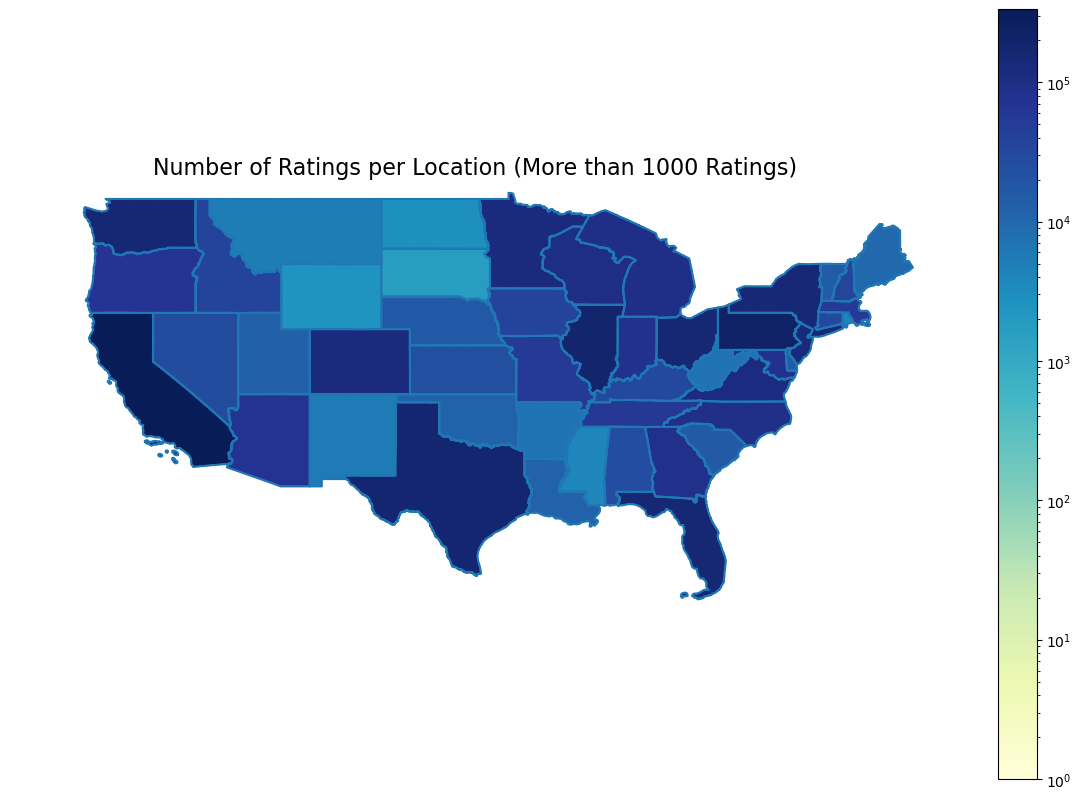

In [6]:
shapefile_path = r'C:\Users\Qrnqult\OneDrive\Documents\GitHub\ada-2024-project-data-crusadas\tl_2024_us_state\tl_2024_us_state.shp'
us = gpd.read_file(shapefile_path)
print(us.columns)

# Merge your ratings data with the world GeoDataFrame
merged = us.merge(nbr_ratings_per_location, how='left', left_on='NAME', right_on='states')

# Fill NaN values in 'nbr_ratings' with 0 for visualization
merged['nbr_ratings'] = merged['nbr_ratings'].fillna(0)

# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.boundary.plot(ax=ax)  # Plot the world boundaries
merged.plot(column='nbr_ratings', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.8', 
            norm=LogNorm(vmin=1, vmax=merged['nbr_ratings'].max()), legend=True)

# Customizing the plot
ax.set_title('Number of Ratings per Location (More than 1000 Ratings)', fontsize=16)
ax.set_xlim([-130, -65])  # x-limits (longitude) for US (adjust for specific areas)
ax.set_ylim([24, 50])
ax.set_axis_off()  # Turn off the axis
plt.show()

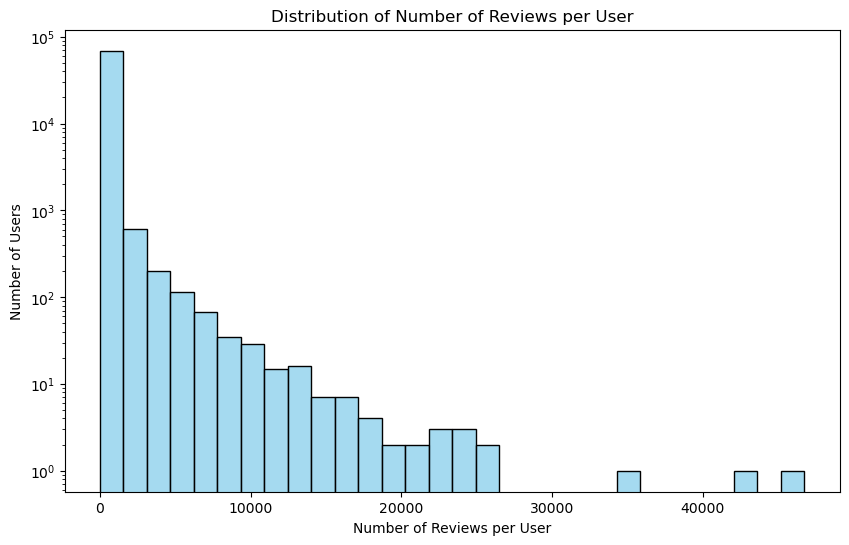

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(rb_users_df['nbr_ratings'], bins=30, kde=False, color="skyblue")  # Adjust bins as needed
plt.xlabel('Number of Reviews per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Number of Reviews per User')
plt.yscale('log')  # Optional: Log scale for better visualization if skewed
plt.show()

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_19660\851525188.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=style_counts.values, y=style_counts.index, palette="viridis")


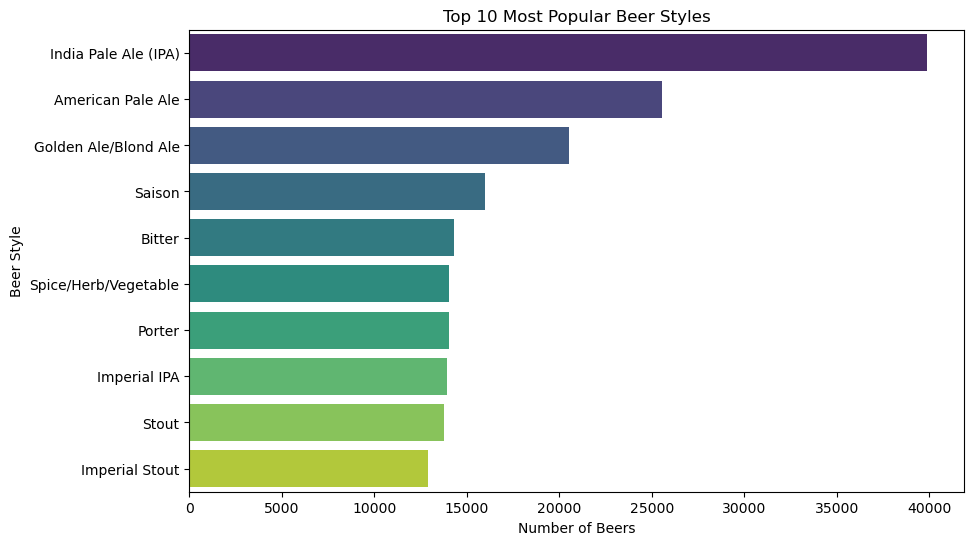

In [8]:
style_counts = rb_beers_df['style'].value_counts().head(10)  # Top 10 beer styles

plt.figure(figsize=(10,6))
sns.barplot(x=style_counts.values, y=style_counts.index, palette="viridis")
plt.title("Top 10 Most Popular Beer Styles")
plt.xlabel("Number of Beers")
plt.ylabel("Beer Style")
plt.show()

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_19660\3462929675.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=style_counts_ratings, y=style_counts_ratings.index.tolist(), palette="viridis")


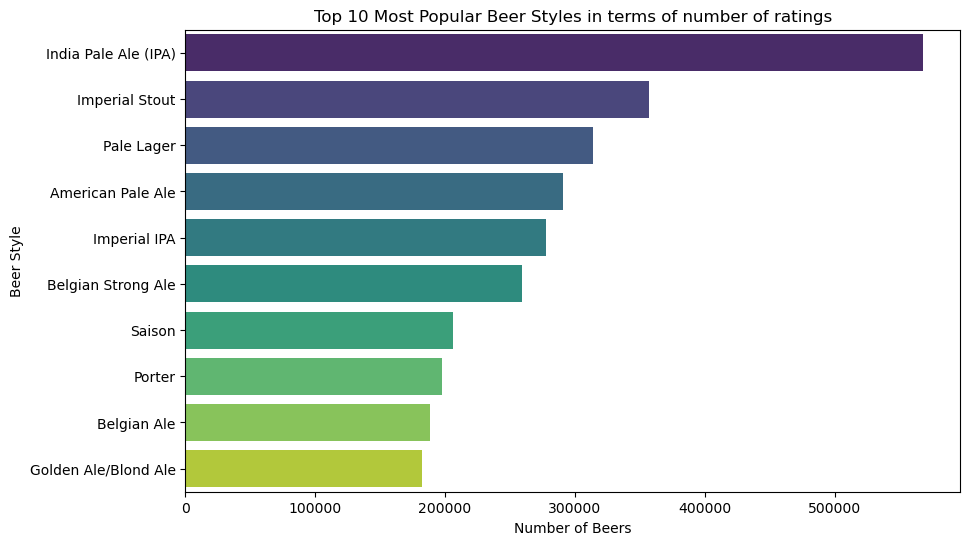

In [9]:
style_counts_ratings = rb_ratings_df['style'].dropna().value_counts().sort_values(ascending=False).head(10)  # Top 10 beer styles

plt.figure(figsize=(10,6))
sns.barplot(x=style_counts_ratings, y=style_counts_ratings.index.tolist(), palette="viridis")
plt.title("Top 10 Most Popular Beer Styles in terms of number of ratings")
plt.xlabel("Number of Beers")
plt.ylabel("Beer Style")
plt.show()

**Most drinken beer per location and per year**

Here we merge to have the useful values

In [64]:
users_df_selected = rb_users_df[['user_id', 'location']]
ratings_df_selected = rb_ratings_df[['user_id', 'brewery_id', 'style', 'abv', 'appearance', 'aroma', 'palate', 'rating', 'taste', 'date']]
users_df_selected.loc[:, 'user_id'] = users_df_selected['user_id'].astype(str)
ratings_df_selected.loc[:, 'user_id'] = ratings_df_selected['user_id'].astype(str)

# Merging on 'user_id'
#Contains the ratings and the location of the users
merged_df = pd.merge(users_df_selected, ratings_df_selected, on='user_id', how='right')
print("NaNs in 'user_id' column of ratings_df_selected:", merged_df['location'].isnull().sum())

rb_breweries_df.rename(columns={'location': 'brewery_location'}, inplace=True)
rb_breweries_df.rename(columns={'id': 'brewery_id'}, inplace=True)

ba_breweries_selected = rb_breweries_df[['brewery_id', 'brewery_location', 'nbr_beers']]

# Perform the merge on `beer_id`
#Contains the ratings, the location of the users and the location of the breweries
final_merged_df = pd.merge(merged_df, ba_breweries_selected, on='brewery_id', how='inner')

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_19660\2689807466.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['175852' '442761' '288889' ... '183139' '82020' '48123']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  users_df_selected.loc[:, 'user_id'] = users_df_selected['user_id'].astype(str)


NaNs in 'user_id' column of ratings_df_selected: 203719


In [65]:
# Assuming final_merged_df is your DataFrame
# Get unique styles from the 'style' column
unique_styles = final_merged_df['style'].unique()

# Print the unique styles
print(unique_styles)

['Pale Lager', 'Stout', 'Golden Ale/Blond Ale', 'Bitter', 'American Pale Ale', ..., 'Saké - Koshu', 'Saké - Taru', 'Saké - Honjozo', 'Saké - Genshu', 'Saké - Futsu-shu']
Length: 93
Categories (93, object): ['Abbey Dubbel', 'Abbey Tripel', 'Abt/Quadrupel', 'Altbier', ..., 'Saké - Nigori', 'Saké - Taru', 'Saké - Tokubetsu', 'Saké - Futsu-shu']


In [66]:
macro_group = {
    'IPA': ['Black IPA', 'India Pale Ale (IPA)', 'Session IPA', 'Imperial IPA']
}

In [67]:
final_merged_df['datetime'] = pd.to_datetime(final_merged_df['date'], unit='s')

# Extract the year from the datetime
final_merged_df['year'] = final_merged_df['datetime'].dt.year
# Extract the month from the datetime
final_merged_df['month'] = final_merged_df['datetime'].dt.month
#Delete unused columns
final_merged_df = final_merged_df.drop('datetime', axis=1)
final_merged_df = final_merged_df.drop('date', axis=1)

def categorize_macro_group(style):
    for key, styles in macro_group.items():
        if style in styles:
            return key
    return 'Other'

final_merged_df['macro_group'] = final_merged_df['style'].apply(categorize_macro_group)

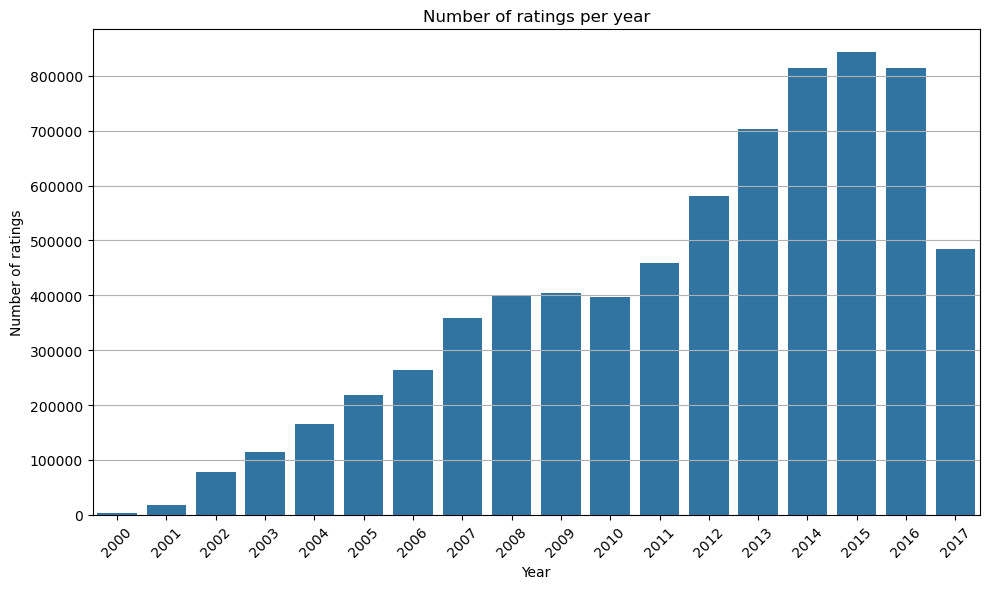

In [49]:
per_year = final_merged_df.groupby(['year']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.barplot(data=per_year, x='year', y='count')
plt.title('Number of ratings per year')
plt.xlabel('Year')
plt.ylabel('Number of ratings')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add grid lines for better visualization
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


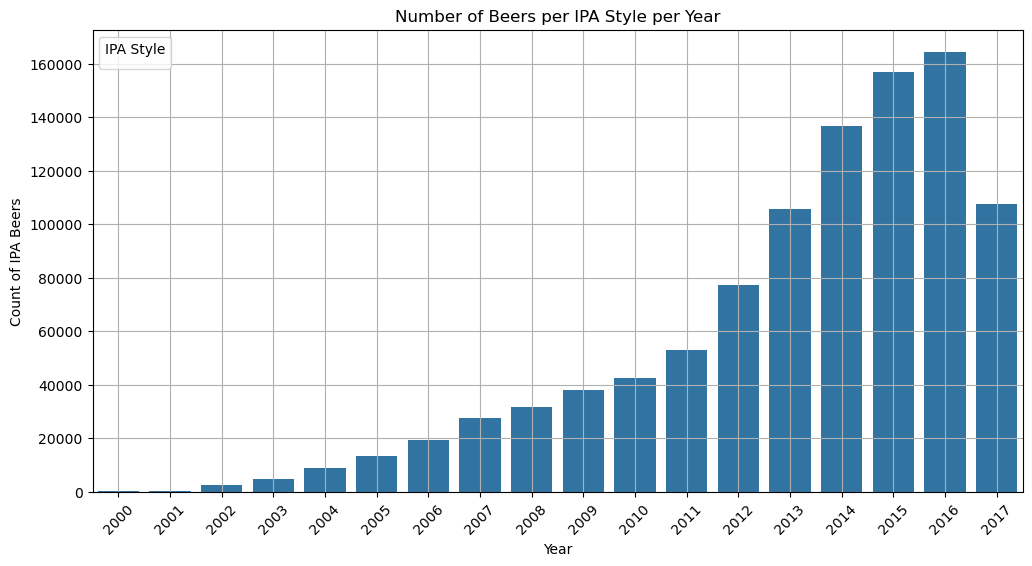

In [68]:
per_year_IPA_total = final_merged_df[final_merged_df['macro_group'] == 'IPA'].groupby(['year']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.barplot(data=per_year_IPA_total, x='year', y='count')

# Customize the plot
plt.title('Number of Beers per IPA Style per Year')
plt.xlabel('Year')
plt.ylabel('Count of IPA Beers')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='IPA Style')  # Add a legend to differentiate IPA styles
plt.grid(True)
plt.show()

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_19660\3881277126.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  per_year_IPA = final_merged_df[final_merged_df['macro_group'] == 'IPA'].groupby(['year', 'style']).size().reset_index(name='count')


                      year  count
style                            
Black IPA             2000      1
Imperial IPA          2000      1
India Pale Ale (IPA)  2000     85
Black IPA             2001      1
Imperial IPA          2001     17
...                    ...    ...
Session IPA           2016  18323
Black IPA             2017   7043
Imperial IPA          2017  27425
India Pale Ale (IPA)  2017  62540
Session IPA           2017  10714

[71 rows x 2 columns]


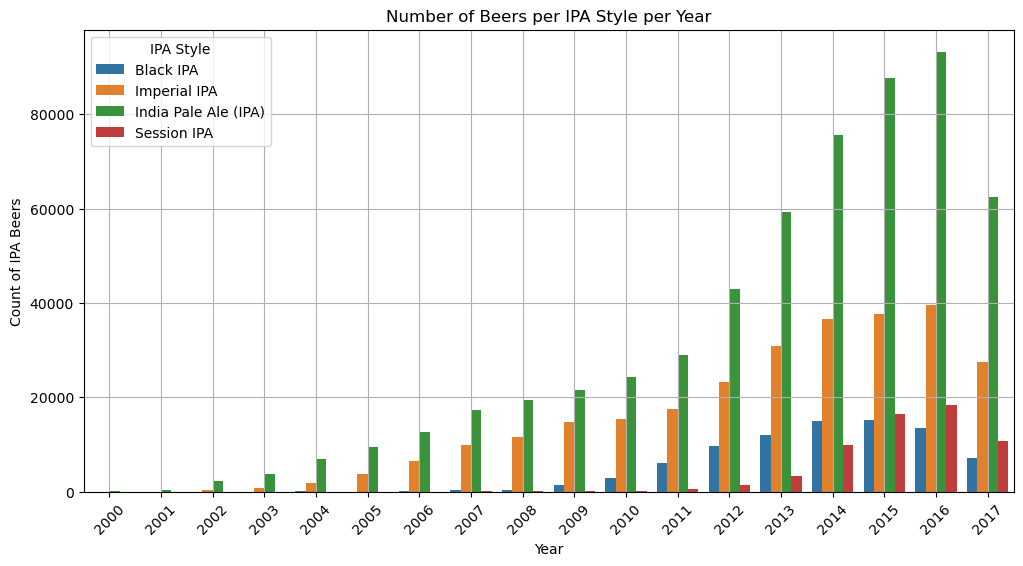

In [69]:
# Group by 'year' and 'macro_group' (IPA style) and count occurrences
per_year_IPA = final_merged_df[final_merged_df['macro_group'] == 'IPA'].groupby(['year', 'style']).size().reset_index(name='count')
per_year_IPA = per_year_IPA[(per_year_IPA['count'] > 0)]
per_year_IPA = per_year_IPA.set_index('style')
print(per_year_IPA)

# Plotting the data with one bar per IPA style for each year
plt.figure(figsize=(12, 6))
sns.barplot(data=per_year_IPA, x='year', y='count', hue=per_year_IPA.index.tolist())

# Customize the plot
plt.title('Number of Beers per IPA Style per Year')
plt.xlabel('Year')
plt.ylabel('Count of IPA Beers')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='IPA Style')  # Add a legend to differentiate IPA styles
plt.grid(True)
plt.show()


In [70]:
#We decided to keep only the years after 2007 for our analysis over the years:
final_merged_df = final_merged_df[final_merged_df['year'] >= 2008]

In [71]:
#Here we compute the percentage of beer beeing IPA per year

grouped = final_merged_df.groupby(['year', 'macro_group']).size().reset_index(name='count')

# Group by year to get total counts
total_count_per_year = final_merged_df.groupby('year').size().reset_index(name='total_count')

# Merge the counts with total counts
merged = pd.merge(grouped, total_count_per_year, on='year')

# Calculate the percentage
merged['percentage'] = (merged['count'] / merged['total_count']) * 100

# Filter to show only the macro group 'IPA'
result = merged[merged['macro_group'] == 'IPA'][['year', 'count', 'total_count', 'percentage']]

print(result)

    year   count  total_count  percentage
0   2008   31588       400291    7.891259
2   2009   37888       404951    9.356194
4   2010   42679       397754   10.729999
6   2011   53154       458162   11.601573
8   2012   77377       580999   13.317923
10  2013  105711       703815   15.019714
12  2014  136798       814683   16.791562
14  2015  156993       842672   18.630381
16  2016  164523       813593   20.221782
18  2017  107722       485115   22.205456


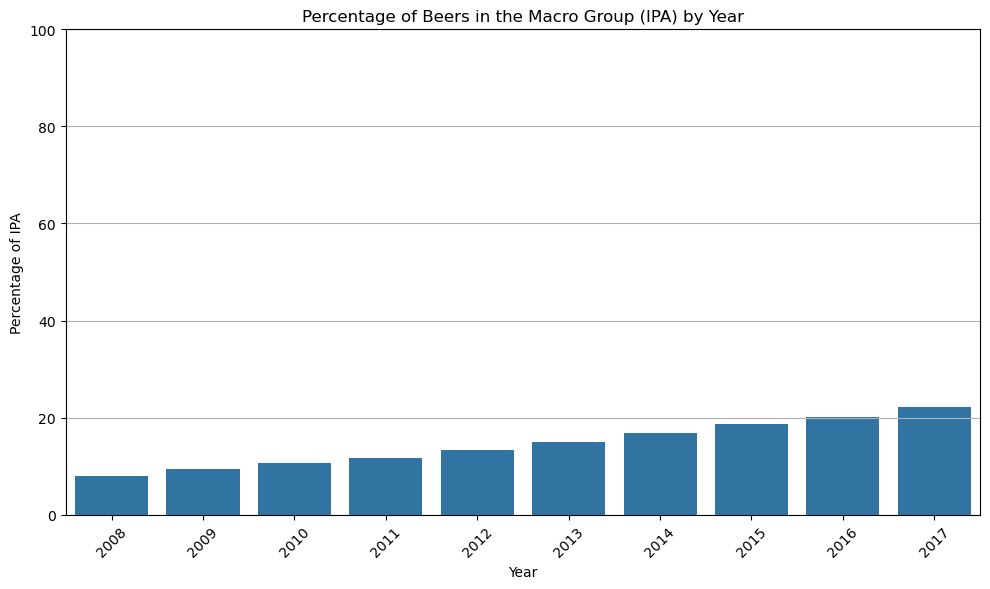

In [72]:
plt.figure(figsize=(10, 6))
sns.barplot(data=result, x='year', y='percentage')
plt.title('Percentage of Beers in the Macro Group (IPA) by Year')
plt.xlabel('Year')
plt.ylabel('Percentage of IPA')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100
plt.grid(axis='y')  # Add grid lines for better visualization
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

**IPA in top 3**

In [73]:
def filter_location(min_ratings, final_merged_df):
    location_ratings = final_merged_df.groupby('location').count()

    # Filter locations with more than 1000 ratings
    locations_over_min = location_ratings[location_ratings['rating'] > min_ratings].index

    # Filter the original DataFrame to include only these locations
    return final_merged_df[final_merged_df['location'].isin(locations_over_min)]

location_df = filter_location(1000, final_merged_df)
beer_counts = location_df.groupby(['location', 'year', 'style']).size().reset_index(name='count')
print(beer_counts)

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_19660\4175686313.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  beer_counts = location_df.groupby(['location', 'year', 'style']).size().reset_index(name='count')


         location  year             style  count
0       Australia  2008      Abbey Dubbel     60
1       Australia  2008      Abbey Tripel    100
2       Australia  2008     Abt/Quadrupel     31
3       Australia  2008           Altbier      4
4       Australia  2008         Amber Ale     73
...           ...   ...               ...    ...
101365      Wales  2017   Saké - Namasaké      0
101366      Wales  2017     Saké - Nigori      0
101367      Wales  2017       Saké - Taru      0
101368      Wales  2017  Saké - Tokubetsu      0
101369      Wales  2017  Saké - Futsu-shu      0

[101370 rows x 4 columns]


In [74]:
#For each year and location, give a rank for each beer styles. For example if Altbier has the most ratings for 2006 in Australia,
#we assign it as rank 1
beer_counts['rank'] = beer_counts.groupby(['location', 'year'])['count'].rank(method='first', ascending=False)

In [75]:
#For each year and location, it gives the most rated beer
top_styles = beer_counts[beer_counts['rank'] <= 1]

# Sort the result for easier readability
#This gives the top beers per year and per location
top_styles = top_styles.sort_values(['location', 'year', 'rank'])

In [76]:
print(top_styles)

         location  year                 style  count  rank
50      Australia  2008            Pale Lager    479   1.0
143     Australia  2009            Pale Lager    530   1.0
236     Australia  2010            Pale Lager    453   1.0
329     Australia  2011            Pale Lager    419   1.0
411     Australia  2012  India Pale Ale (IPA)    682   1.0
...           ...   ...                   ...    ...   ...
100918      Wales  2013                Bitter     84   1.0
101011      Wales  2014                Bitter     15   1.0
101123      Wales  2015  Golden Ale/Blond Ale     10   1.0
101223      Wales  2016  India Pale Ale (IPA)     13   1.0
101316      Wales  2017  India Pale Ale (IPA)     12   1.0

[1090 rows x 5 columns]


In [77]:
#is_IPA is true if for a given location and given year, the best beer is an IPA
top_styles['is_IPA'] = top_styles['style'].isin(macro_group['IPA'])

# For each year and location, check if there's an IPA style
ipa_presence = (
    top_styles.groupby(['location', 'year'])['is_IPA']
    .any()  # Check if there's any IPA style in each group  # Replace True/False with Yes/No
    .reset_index(name='IPA_Present')  # Reset index and name the column
)

In [78]:
print(ipa_presence)

       location  year  IPA_Present
0     Australia  2008        False
1     Australia  2009        False
2     Australia  2010        False
3     Australia  2011        False
4     Australia  2012         True
...         ...   ...          ...
1085      Wales  2013        False
1086      Wales  2014        False
1087      Wales  2015        False
1088      Wales  2016         True
1089      Wales  2017         True

[1090 rows x 3 columns]


In [79]:
def compute_best_countries_per_year(ipa_presence):

    #Check if for all countries the 10 years range is present
    check_countries = ipa_presence.groupby('location').count().reset_index()
    print(check_countries[check_countries['year'] < 10])

    #Print the total number of countries
    total_countries = ipa_presence['location'].nunique()
    print("Total number of countries: ", total_countries)

    # Filter for rows where IPA_Present is "Yes"
    ipa_countries = ipa_presence[ipa_presence['IPA_Present'] == True]

    # Group by year and count unique locations
    #This gives the number of countries that have as the best beer beeing an IPA per year
    ipa_presence_count = ipa_countries.groupby('year')['location'].nunique().reset_index(name='num_countries_with_IPA')

    # Display the result
    print(ipa_presence_count)

    return ipa_presence_count, total_countries, 

ipa_presence_count, total_countries = compute_best_countries_per_year(ipa_presence)

Empty DataFrame
Columns: [location, year, IPA_Present]
Index: []
Total number of countries:  109
   year  num_countries_with_IPA
0  2008                      25
1  2009                      36
2  2010                      41
3  2011                      43
4  2012                      55
5  2013                      65
6  2014                      68
7  2015                      82
8  2016                      89
9  2017                      88


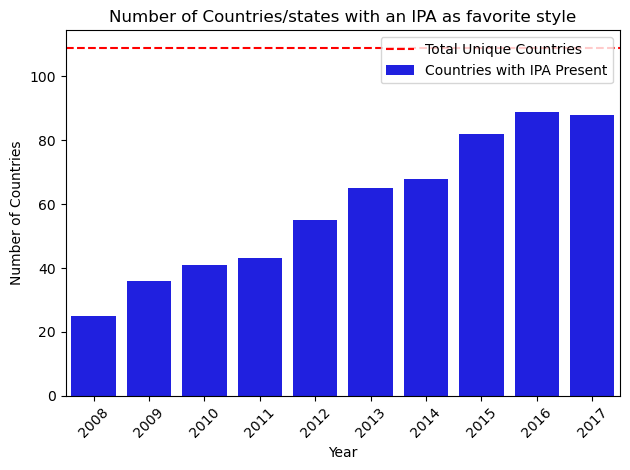

In [80]:
# Bar plot for the number of countries with IPA
sns.barplot(x='year', y='num_countries_with_IPA', data=ipa_presence_count, color='blue', label='Countries with IPA Present')

# Adding a line plot for total countries (this will be a constant line across years)
plt.axhline(y=total_countries, color='red', linestyle='--', label='Total Unique Countries')

# Customize the plot
plt.title('Number of Countries/states with an IPA as favorite style')
plt.xlabel('Year')
plt.ylabel('Number of Countries')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

**How envolve the ratings over year?**

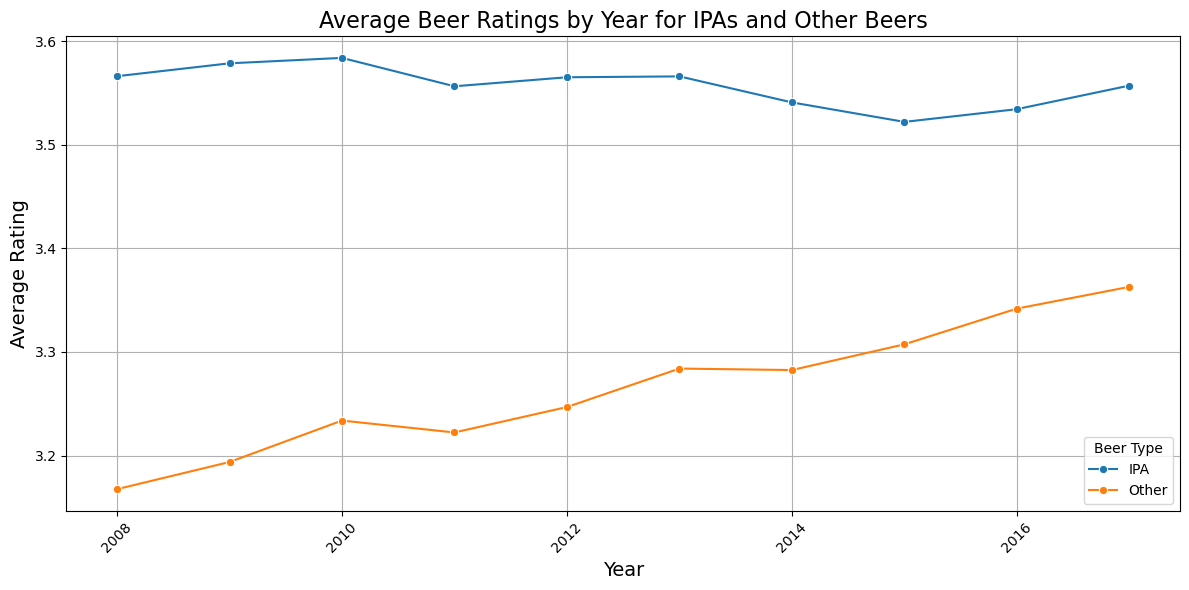

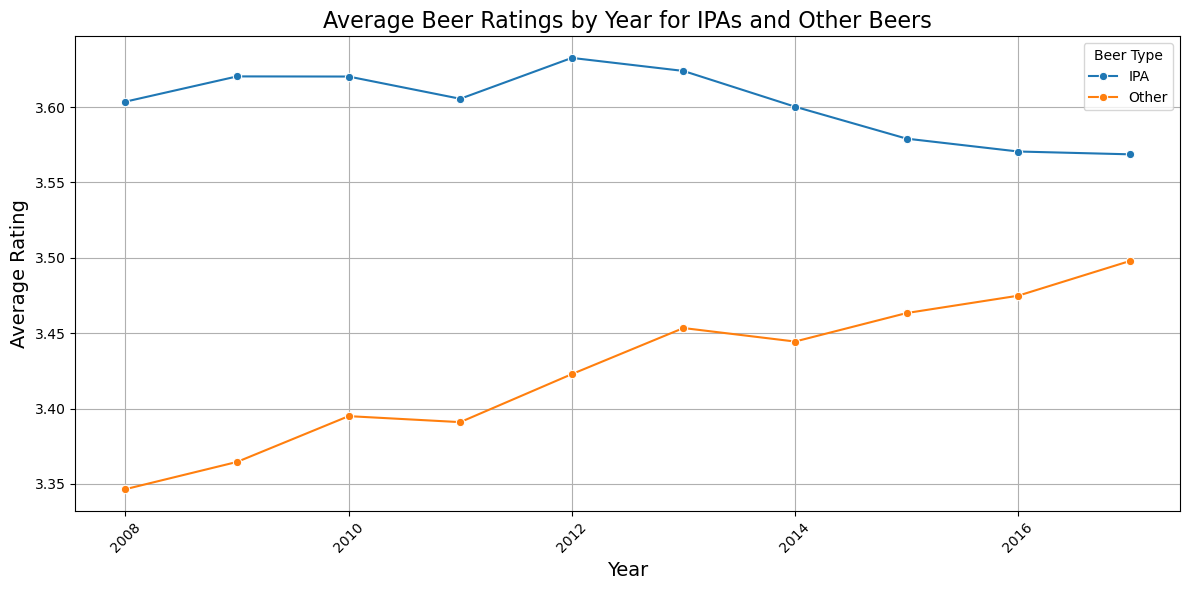

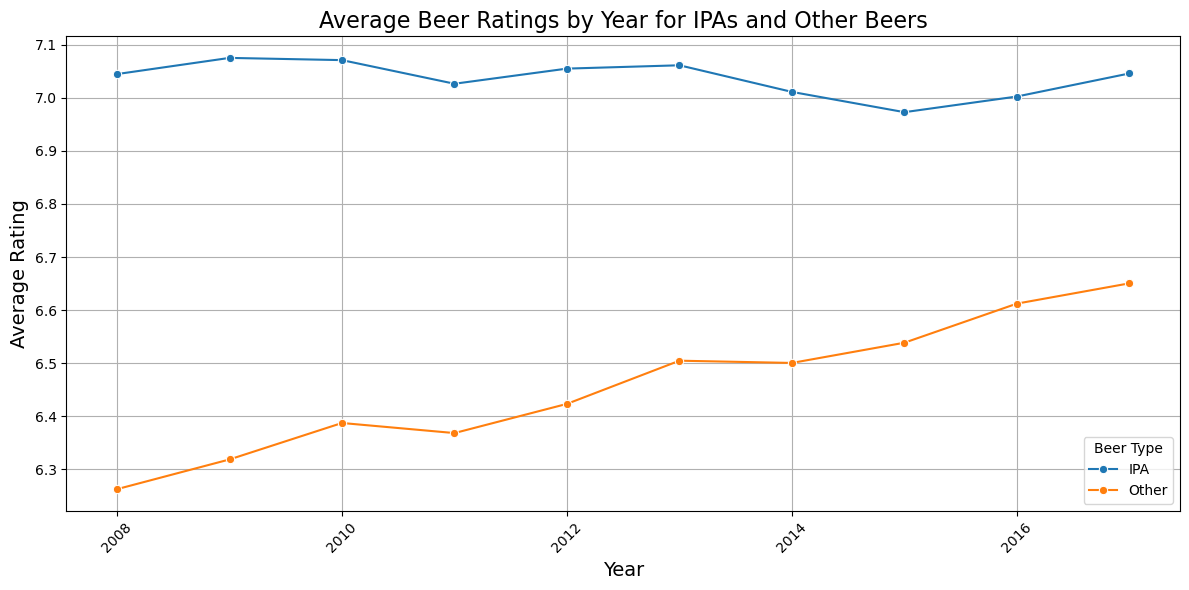

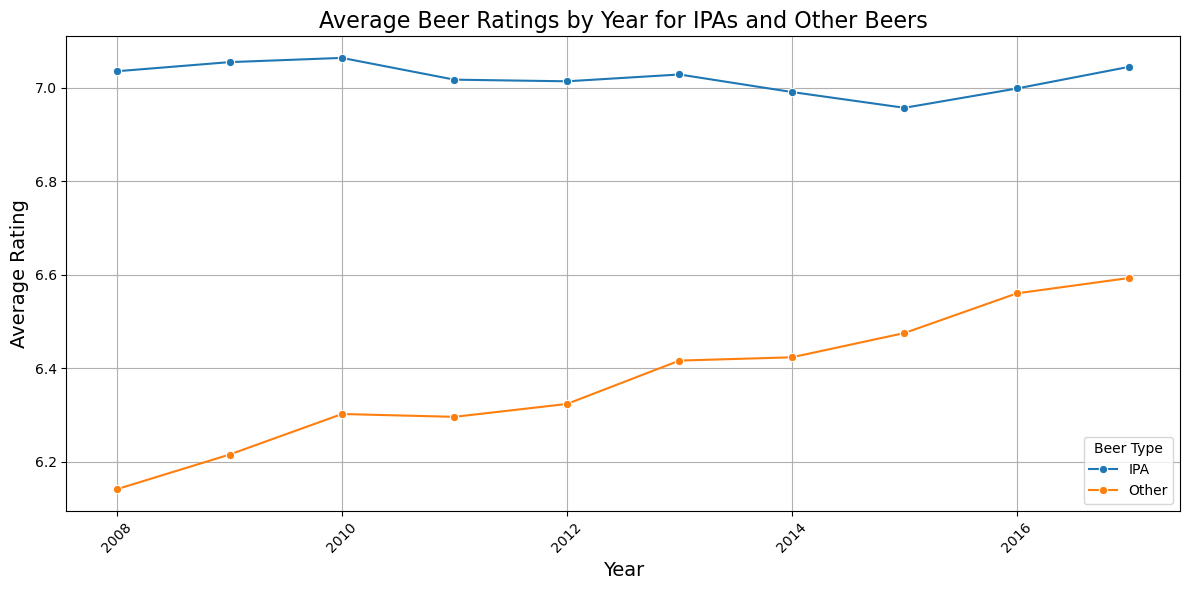

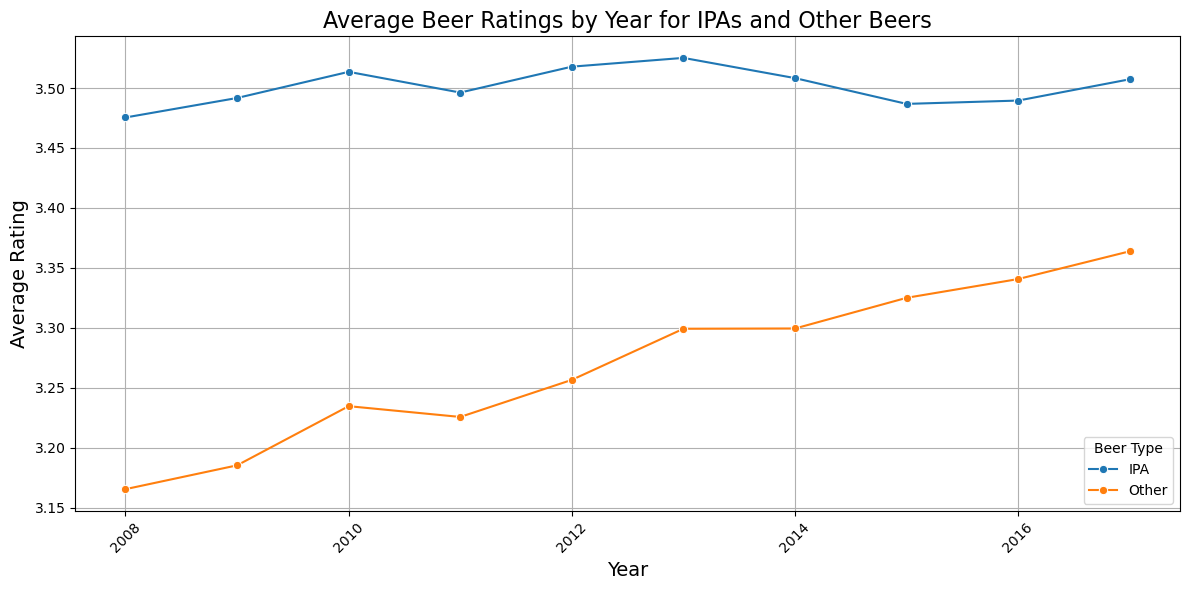

In [124]:
def envolve_rating(rating_kind):
    average_ratings = final_merged_df.groupby(['year', 'macro_group'])[rating_kind].mean().reset_index()
    average_ratings.rename(columns={rating_kind: 'average_rating'}, inplace=True)
    #print(average_ratings)
    plt.figure(figsize=(12, 6))

    # Create a line plot for average ratings
    sns.lineplot(data=average_ratings, x='year', y='average_rating', hue='macro_group', marker='o')

    # Customize the plot
    plt.title('Average Beer Ratings by Year for IPAs and Other Beers', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Average Rating', fontsize=14)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend(title='Beer Type')
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()
#apperance, taste, aroma, palate, rating
envolve_rating('rating')
envolve_rating('appearance')
envolve_rating('taste')
envolve_rating('aroma')
envolve_rating('palate')

**Is that true that every country rates better IPAs than other beers?**

In [83]:
filtered_df = filter_location(5000, final_merged_df)
average_ratings = filtered_df.groupby(['location', 'macro_group'])['rating'].mean().reset_index()

print(average_ratings)

                         location macro_group    rating
0                       Australia         IPA  3.609373
1                       Australia       Other  3.213833
2                         Austria         IPA  3.594772
3                         Austria       Other  3.326516
4                         Belarus         IPA  3.541753
..                            ...         ...       ...
151     United States, Washington       Other  3.387273
152  United States, West Virginia         IPA  3.529588
153  United States, West Virginia       Other  3.266959
154      United States, Wisconsin         IPA  3.579325
155      United States, Wisconsin       Other  3.355092

[156 rows x 3 columns]


C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_19660\623373294.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  american_states['states'] = american_states['location'].apply(clean_states)


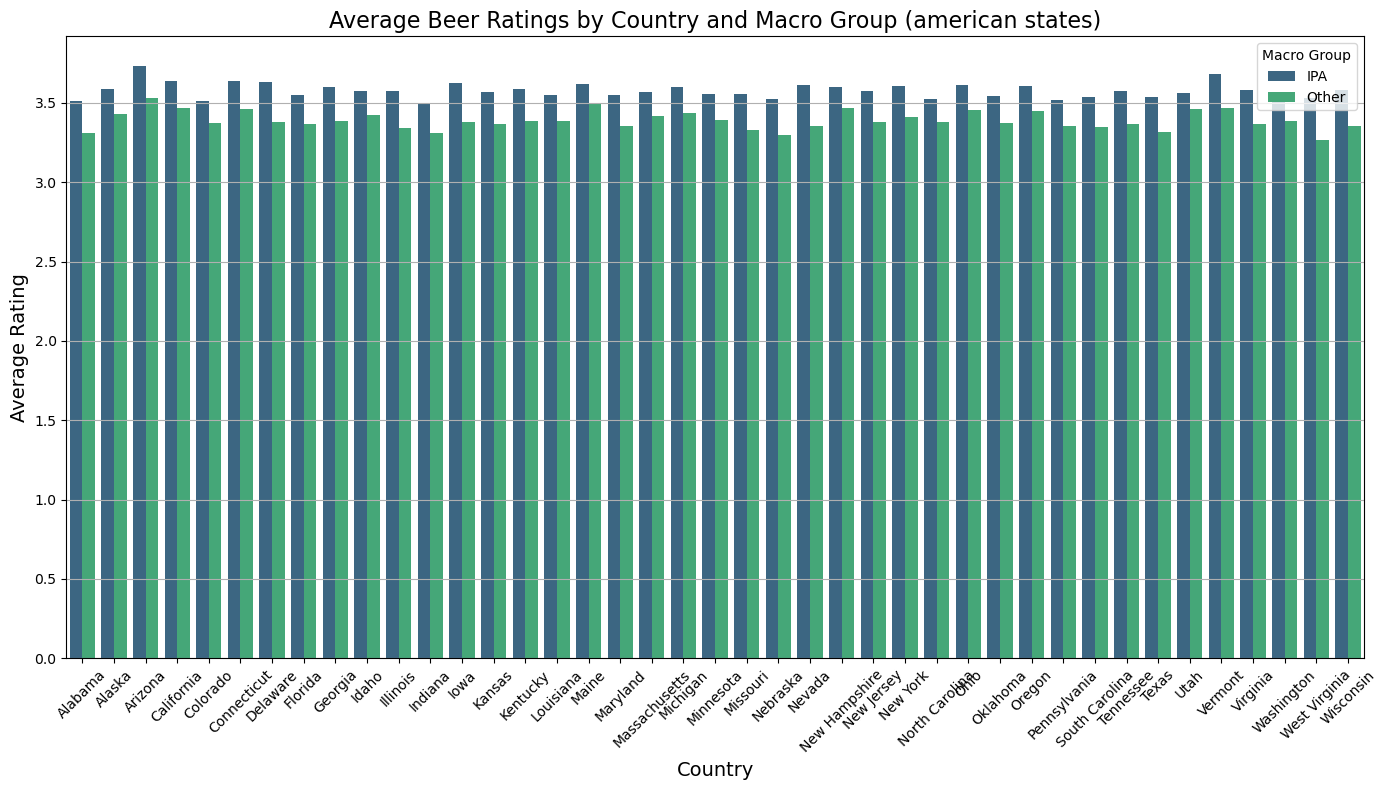

In [84]:
average_ratings.rename(columns={'rating': 'average_rating'}, inplace=True)

american_states = average_ratings[average_ratings['location'].str.startswith("United States")]
non_american_states = average_ratings[~average_ratings['location'].str.startswith("United States")]

american_states['states'] = american_states['location'].apply(clean_states)

# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Create a bar plot
sns.barplot(data=american_states, x='states', y='average_rating', hue='macro_group', palette='viridis')

# Customize the plot
plt.title('Average Beer Ratings by Country and Macro Group (american states)', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Macro Group')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

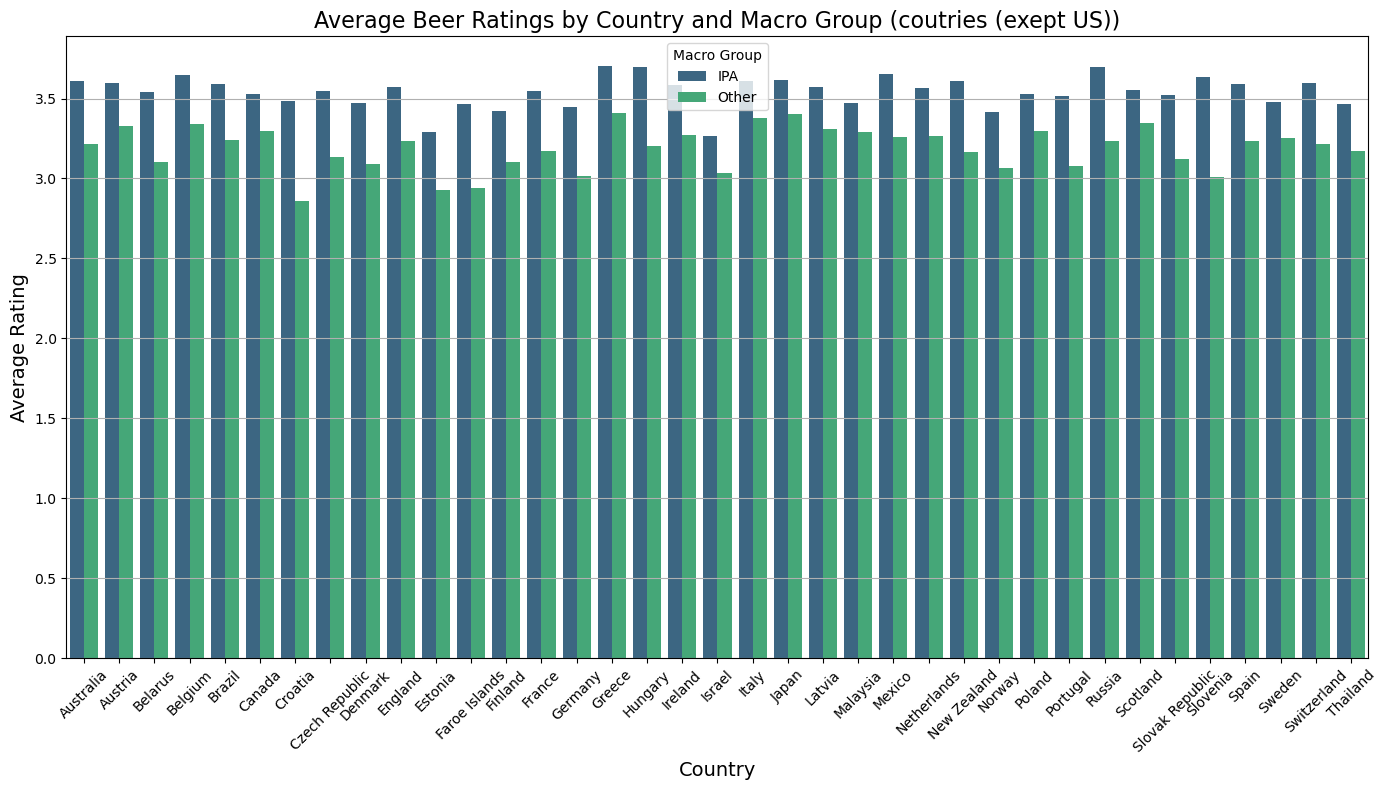

In [85]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Create a bar plot
sns.barplot(data=non_american_states, x='location', y='average_rating', hue='macro_group', palette='viridis')

# Customize the plot
plt.title('Average Beer Ratings by Country and Macro Group (coutries (exept US))', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Macro Group')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

**Let's investigate if the ratings of big or small raters are different**

In [86]:
user_rating_counts = final_merged_df.groupby('user_id')['rating'].count().reset_index()
user_rating_counts.columns = ['user_id', 'rating_count']  # Rename columns for clarity

In [87]:
print(user_rating_counts)

      user_id  rating_count
0      100007            73
1      100011            46
2      100012            30
3      100021             1
4      100022             7
...       ...           ...
58335   99974             1
58336   99986             1
58337   99992             2
58338   99994            10
58339   99998           635

[58340 rows x 2 columns]


In [88]:
number_ratings = 500
users_above = user_rating_counts[user_rating_counts['rating_count'] > number_ratings]
users_below = user_rating_counts[user_rating_counts['rating_count'] <= number_ratings]

In [89]:
#Seperate the dataframe final_merged_df between big and small users
big_users = final_merged_df[final_merged_df['user_id'].isin(users_above['user_id'])]
small_users = final_merged_df[final_merged_df['user_id'].isin(users_below['user_id'])]

In [90]:
print(big_users.head())

  user_id location  brewery_id       style  abv  appearance  aroma  palate  \
0  175852   Poland        3198  Pale Lager  5.0         2.0    4.0     2.0   
3  250510    Spain        3198  Pale Lager  5.2         4.0    3.0     1.0   
4  122778  Germany        3198  Pale Lager  5.2         2.0    4.0     2.0   
5  227834  Germany        3198  Pale Lager  5.2         2.0    3.0     2.0   
6   83106  Germany        3198  Pale Lager  5.2         4.0    5.0     4.0   

   rating  taste brewery_location  nbr_beers  year  month macro_group  
0     2.0    4.0            Gabon          3  2016      4       Other  
3     1.5    2.0            Gabon          3  2016      1       Other  
4     1.9    4.0            Gabon          3  2015     10       Other  
5     1.9    3.0            Gabon          3  2015     10       Other  
6     2.6    5.0            Gabon          3  2015     10       Other  


In [91]:
#Compute the avg rating for IPA and Other for big and small users
big_avg_ratings = big_users.groupby('macro_group')['rating'].mean().reset_index()
small_avg_ratings = small_users.groupby('macro_group')['rating'].mean().reset_index()
avg_ratings = pd.merge(big_avg_ratings, small_avg_ratings, on='macro_group', suffixes=('_big', '_small'))
avg_ratings.columns = ['beer_type', 'big_users', 'small_users']

In [92]:
print(avg_ratings)

  beer_type  big_users  small_users
0       IPA   3.525487     3.643688
1     Other   3.257558     3.342786


  beer_type   user_group  average_rating
0       IPA    big_users        3.525487
1     Other    big_users        3.257558
2       IPA  small_users        3.643688
3     Other  small_users        3.342786


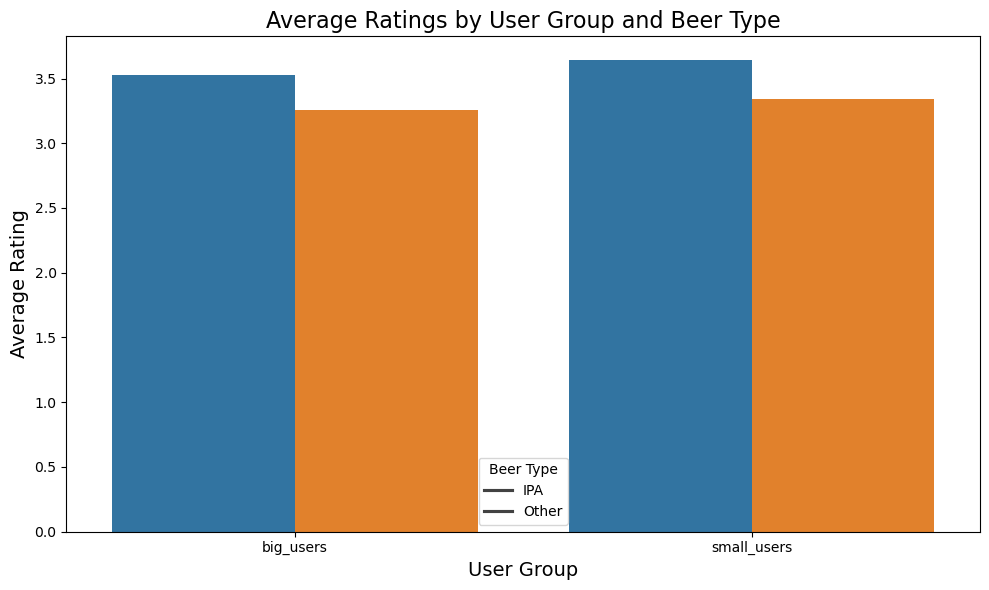

In [93]:
avg_ratings_melted = avg_ratings.melt(id_vars='beer_type', 
                                        value_vars=['big_users', 'small_users'],
                                        var_name='user_group', 
                                        value_name='average_rating')

print(avg_ratings_melted)

# Create a bar plot with user groups on the x-axis
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_ratings_melted, x='user_group', y='average_rating', hue='beer_type')

# Add titles and labels
plt.title('Average Ratings by User Group and Beer Type', fontsize=16)
plt.xlabel('User Group', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=0)  # No rotation needed for x-axis labels
plt.legend(title='Beer Type', labels=['IPA', 'Other'])
plt.tight_layout()  # Adjust layout for better fit

# Show the plot
plt.show()

In [94]:
print(len(users_above))
print(len(users_below))

2193
56147


**Let's investigate how the number of ratings change per location between IPA and other beers**

In [95]:
filtered_df_copy = filter_location(5000, final_merged_df).copy()
filtered_df_copy['is_IPA'] = filtered_df_copy['style'].isin(macro_group['IPA'])

In [96]:
location_ipa_percentage = filtered_df_copy.groupby('location').agg(
    IPA_Percentage=('is_IPA', lambda x: (x.sum() / len(x)) * 100)
).reset_index()

# Display the result
print(location_ipa_percentage)
location_ipa_percentage_sorted = location_ipa_percentage.sort_values(by='IPA_Percentage', ascending=False)

                        location  IPA_Percentage
0                      Australia       16.009978
1                        Austria       16.915688
2                        Belarus       13.570229
3                        Belgium       11.321006
4                         Brazil       11.239085
..                           ...             ...
73        United States, Vermont       19.646697
74       United States, Virginia       19.307162
75     United States, Washington       20.557205
76  United States, West Virginia       16.977286
77      United States, Wisconsin       15.506815

[78 rows x 2 columns]


In [97]:
american_states = location_ipa_percentage_sorted[location_ipa_percentage_sorted['location'].str.startswith("United States")]
non_american_states = location_ipa_percentage_sorted[~location_ipa_percentage_sorted['location'].str.startswith("United States")]

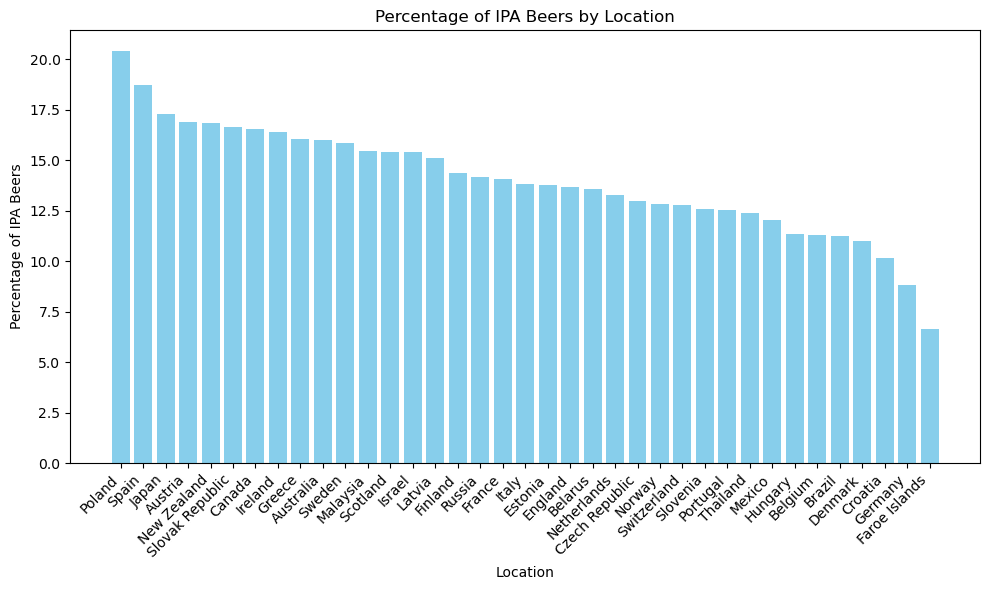

In [98]:
plt.figure(figsize=(10, 6))

# Create a bar chart
plt.bar(non_american_states['location'], non_american_states['IPA_Percentage'], color='skyblue')

# Add labels and title
plt.xlabel('Location')
plt.ylabel('Percentage of IPA Beers')
plt.title('Percentage of IPA Beers by Location')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_19660\1220279976.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  american_states['states'] = american_states['location'].apply(clean_states)


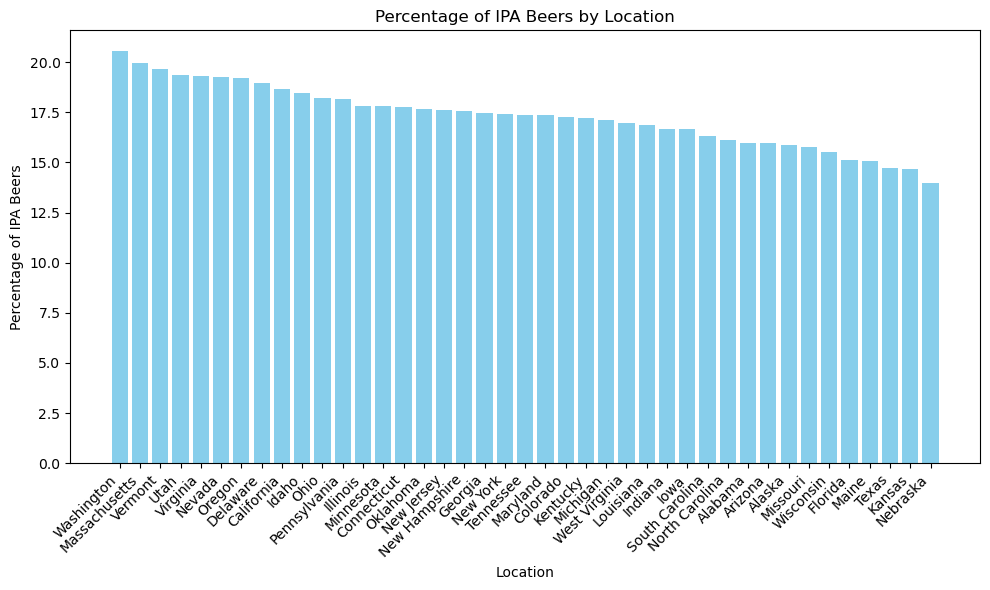

In [99]:
american_states['states'] = american_states['location'].apply(clean_states)
plt.figure(figsize=(10, 6))

# Create a bar chart
plt.bar(american_states['states'], american_states['IPA_Percentage'], color='skyblue')

# Add labels and title
plt.xlabel('Location')
plt.ylabel('Percentage of IPA Beers')
plt.title('Percentage of IPA Beers by Location')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

**Let's investigate if IPAs tend to come from bigger breweries**

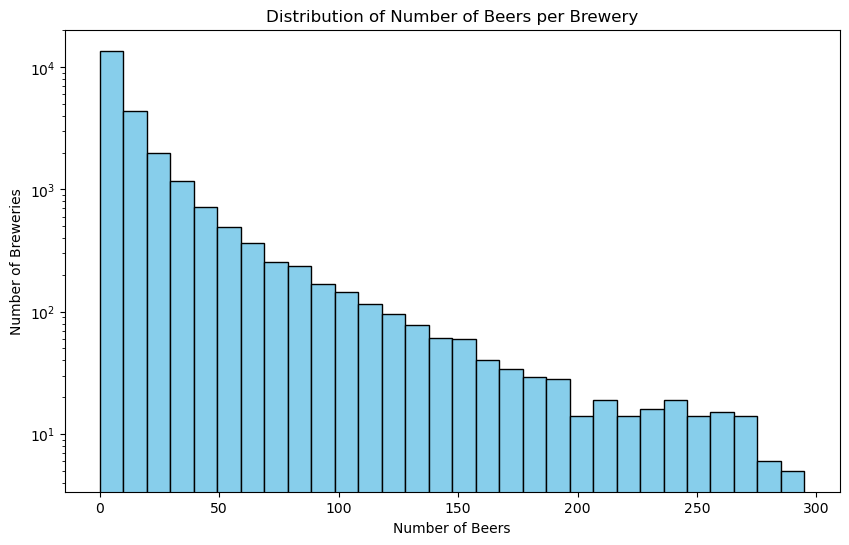

In [100]:
plt.figure(figsize=(10, 6))
plt.hist(rb_breweries_df['nbr_beers'], bins=30, color='skyblue', edgecolor='black', log=True)
plt.title('Distribution of Number of Beers per Brewery')
plt.xlabel('Number of Beers')
plt.ylabel('Number of Breweries')
plt.show()

In [101]:
merged_df_brew = pd.merge(rb_beers_df, rb_breweries_df, left_on='brewery_id', right_on='brewery_id', how='left')
merged_df_brew['is_IPA'] = merged_df_brew['style'].isin(macro_group['IPA'])
print(merged_df_brew)

        beer_id               beer_name  brewery_id       brewery_name  \
0        410549       33 Export (Gabon)        3198            Sobraga   
1        105273     Castel Beer (Gabon)        3198            Sobraga   
2         19445                   Régab        3198            Sobraga   
3        155699  Ards Bally Black Stout       13538   Ards Brewing Co.   
4        239097        Ards Belfast 366       13538   Ards Brewing Co.   
...         ...                     ...         ...                ...   
442076   189684           Stela Selekt         1107       Stefani & Co   
442077    84884   Hotel Martini Donauer        9355      Hotel Martini   
442078    93783            Birra Rozafa        9928     Rozafa Brewery   
442079   220897            Svejk Blonde       17155  Svejk Beer Garden   
442080   220898              Svejk Dark       17155  Svejk Beer Garden   

                       style  nbr_ratings  overall_score  style_score   avg  \
0                 Pale Lager    

In [102]:
average_beers_by_brewery = merged_df_brew.groupby(['is_IPA'])['nbr_beers'].mean().reset_index()
print(average_beers_by_brewery)

   is_IPA  nbr_beers
0   False  70.437270
1    True  77.904381


It looks like that in average IPA beers are brewed by bigger breweries

In [103]:
#Let's say that a big brewery is a brewery brewing more than 200 beers. Let's see how many ratings
#come from small or big breweries depending if it's an IPA or not
final_merged_df['big_brewery'] = final_merged_df['nbr_beers'] > 200
grouped_df = final_merged_df.groupby(['macro_group', 'big_brewery']).size().reset_index(name='count')
print(grouped_df)

  macro_group  big_brewery    count
0         IPA        False   749711
1         IPA         True   164722
2       Other        False  4395054
3       Other         True   592548


In [108]:
ipa_count = grouped_df[(grouped_df['macro_group'] == 'IPA') & (grouped_df['big_brewery'] == False)]['count'].values[0]
big_brewery_count = grouped_df[(grouped_df['macro_group'] == 'IPA') & (grouped_df['big_brewery'] == True)]['count'].values[0]

# Performing the calculation
result = big_brewery_count / (ipa_count + big_brewery_count)*100

# Printing the result
print("Percentage big brewery for IPA = ", result)


Percentage big brewery for IPA =  18.013566876960915


In [107]:
non_ipa_count = grouped_df[(grouped_df['macro_group'] == 'Other') & (grouped_df['big_brewery'] == False)]['count'].values[0]
non_ipa_big_brewery_count = grouped_df[(grouped_df['macro_group'] == 'Other') & (grouped_df['big_brewery'] == True)]['count'].values[0]

# Performing the calculation
result = non_ipa_big_brewery_count / (non_ipa_count + non_ipa_big_brewery_count)*100

# Printing the result
print("Percentage big brewery for Other = ", result)

Percentage big brewery for Other =  11.880418686174238


In [109]:
grouped_df = final_merged_df.groupby(['year', 'macro_group', 'big_brewery']).size().reset_index(name='count')
print(grouped_df)

    year macro_group  big_brewery   count
0   2008         IPA        False   24373
1   2008         IPA         True    7215
2   2008       Other        False  326417
3   2008       Other         True   42286
4   2009         IPA        False   29063
5   2009         IPA         True    8825
6   2009       Other        False  324609
7   2009       Other         True   42454
8   2010         IPA        False   33278
9   2010         IPA         True    9401
10  2010       Other        False  312929
11  2010       Other         True   42146
12  2011         IPA        False   41219
13  2011         IPA         True   11935
14  2011       Other        False  358694
15  2011       Other         True   46314
16  2012         IPA        False   60638
17  2012         IPA         True   16739
18  2012       Other        False  443934
19  2012       Other         True   59688
20  2013         IPA        False   84792
21  2013         IPA         True   20919
22  2013       Other        False 

macro_group        IPA      Other
year                             
2008         22.840952  11.468852
2009         23.292335  11.565862
2010         22.027227  11.869605
2011         22.453625  11.435330
2012         21.633043  11.851746
2013         19.788858  12.925678
2014         18.139885  12.621610
2015         15.938927  11.894633
2016         15.265951  11.471336
2017         13.677800  10.804387


<Figure size 1000x600 with 0 Axes>

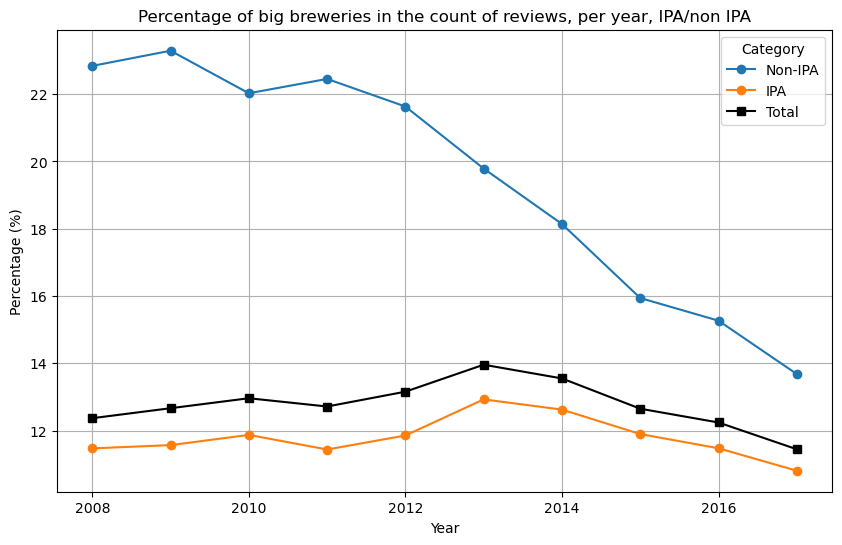

In [110]:
total_counts = grouped_df.groupby(['year', 'macro_group'])['count'].sum().unstack()

# Calculate counts of IPA and non-IPA from big breweries
big_brewery_counts = grouped_df[grouped_df['big_brewery'] == True].groupby(['year', 'macro_group'])['count'].sum().unstack()

# Calculate percentage of IPA and non-IPA from big breweries
percentage_big_brewery = big_brewery_counts.div(total_counts) * 100

#For each year we'll have 
print(percentage_big_brewery)

# Calculate the total beer counts from big breweries and total beer counts for each year
total_big_brewery_counts = grouped_df[grouped_df['big_brewery'] == True].groupby('year')['count'].sum()
total_all_counts = grouped_df.groupby('year')['count'].sum()

# Calculate the total percentage of all beer from big breweries
percentage_total_big_brewery = total_big_brewery_counts.div(total_all_counts) * 100

# Plotting
plt.figure(figsize=(10, 6))

# Plot the percentage of IPA, non-IPA, and total from big breweries
percentage_big_brewery.plot(kind='line', marker='o', linestyle='-', figsize=(10, 6))
plt.plot(percentage_total_big_brewery, marker='s', linestyle='-', color='black', label='Total Big Brewery')

# Adding labels and title
plt.title('Percentage of big breweries in the count of reviews, per year, IPA/non IPA')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.legend(title='Category', labels=['Non-IPA', 'IPA', 'Total'])

# Display the plot
plt.grid(True)
plt.show()

**Let's investigate if the IPA is a seasonal beer**

In [111]:
per_month_df = final_merged_df.groupby('month')['rating'].size().reset_index()
per_month_df = per_month_df.rename(columns={
    'month': 'Month',
    'rating': 'Number of Ratings'
})
print(per_month_df)

    Month  Number of Ratings
0       1             476708
1       2             470207
2       3             516681
3       4             511315
4       5             556810
5       6             524960
6       7             537215
7       8             503192
8       9             445193
9      10             468712
10     11             426179
11     12             464863


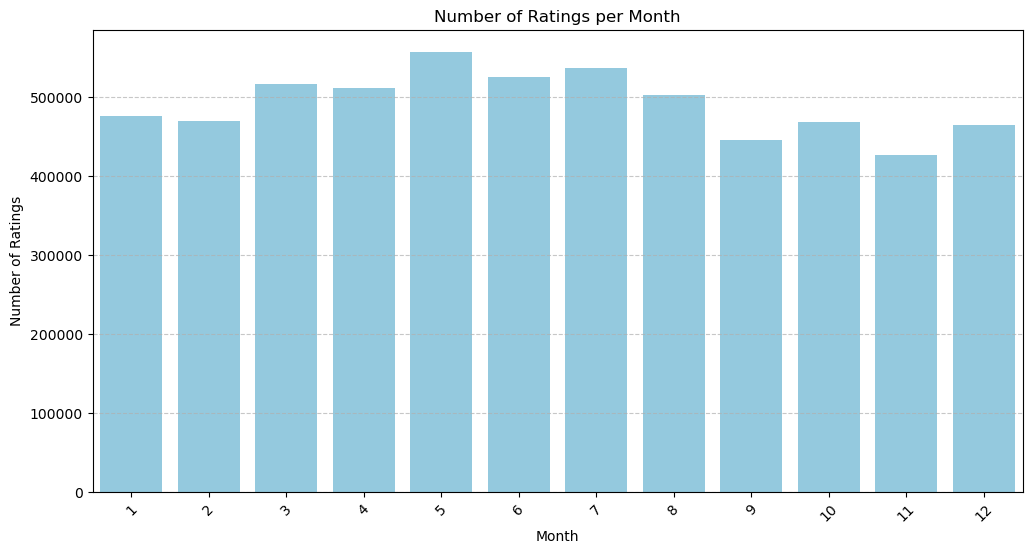

In [112]:
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=per_month_df, x='Month', y='Number of Ratings', color='skyblue')

# Customize the plot
plt.title('Number of Ratings per Month')
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

In [113]:
per_month_df = final_merged_df.groupby(['month', 'macro_group'])['rating'].size().reset_index()
per_month_df = per_month_df.rename(columns={
    'month': 'Month',
    'rating': 'Number of Ratings'
})
print(per_month_df)

    Month macro_group  Number of Ratings
0       1         IPA              67312
1       1       Other             409396
2       2         IPA              71267
3       2       Other             398940
4       3         IPA              81890
5       3       Other             434791
6       4         IPA              83145
7       4       Other             428170
8       5         IPA              92740
9       5       Other             464070
10      6         IPA              86927
11      6       Other             438033
12      7         IPA              87640
13      7       Other             449575
14      8         IPA              76621
15      8       Other             426571
16      9         IPA              67660
17      9       Other             377533
18     10         IPA              71551
19     10       Other             397161
20     11         IPA              63040
21     11       Other             363139
22     12         IPA              64640
23     12       

C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_19660\1692377028.py:4: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.barplot(data=per_month_df, x='Month', y='Number of Ratings', hue='macro_group', color='skyblue')


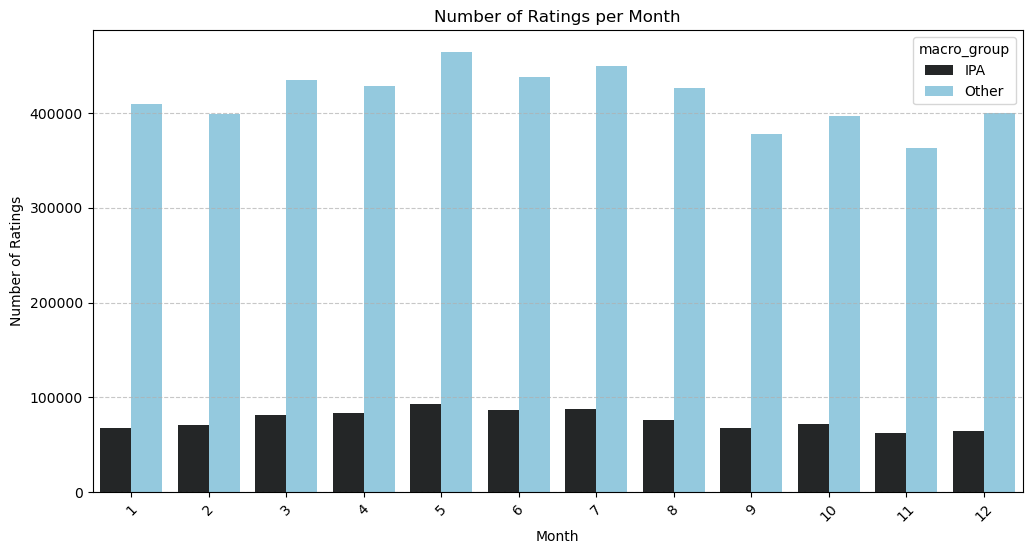

In [114]:
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=per_month_df, x='Month', y='Number of Ratings', hue='macro_group', color='skyblue')

# Customize the plot
plt.title('Number of Ratings per Month')
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

In [115]:
monthly_totals = per_month_df.groupby('Month')['Number of Ratings'].sum().reset_index(name='Total Ratings')

# Merge monthly totals back into the original DataFrame
df = pd.merge(per_month_df, monthly_totals, on='Month')

# Calculate IPA percentage
df['IPA Percentage'] = df.apply(lambda row: (row['Number of Ratings'] / row['Total Ratings']) * 100 
                                if row['macro_group'] == 'IPA' else None, axis=1)

# Drop rows with None in 'IPA Percentage' to only keep IPA rows
ipa_percentages = df.dropna(subset=['IPA Percentage'])[['Month', 'IPA Percentage']]
print(ipa_percentages)

    Month  IPA Percentage
0       1       14.120174
2       2       15.156516
4       3       15.849238
6       4       16.261013
8       5       16.655592
10      6       16.558785
12      7       16.313766
14      8       15.226991
16      9       15.197903
18     10       15.265451
20     11       14.791907
22     12       13.905172


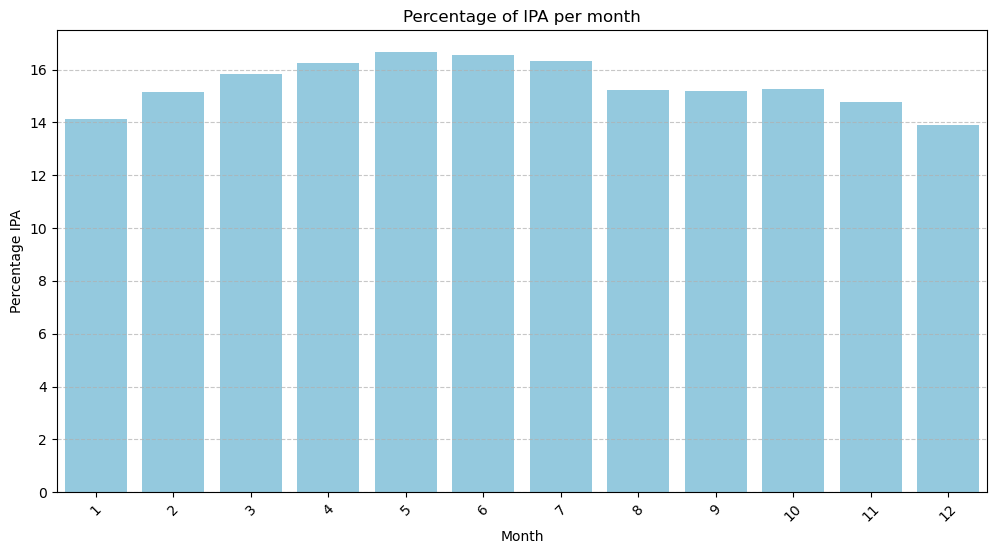

In [116]:
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=ipa_percentages, x='Month', y='IPA Percentage', color='skyblue')

# Customize the plot
plt.title('Percentage of IPA per month')
plt.xlabel('Month')
plt.ylabel('Percentage IPA')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

**Let's find out if there is an evolution in term of amount of alcohol**

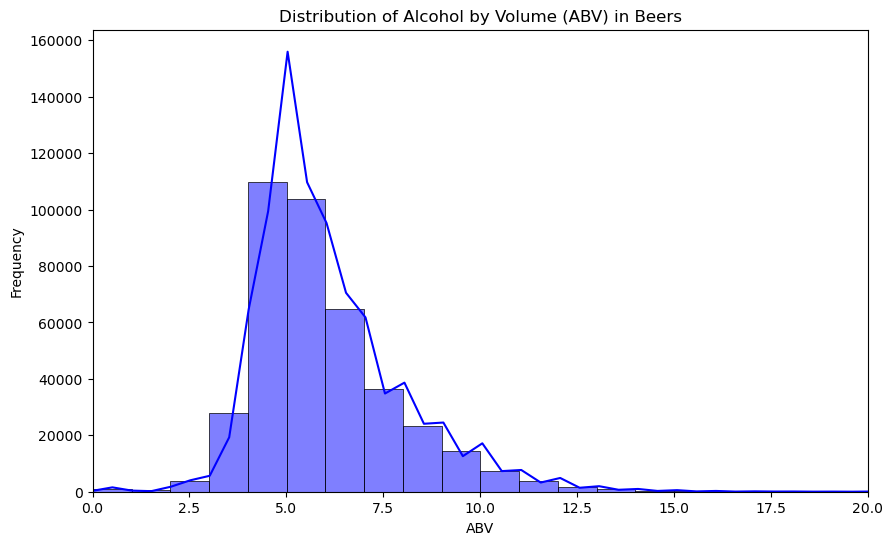

In [5]:
plt.figure(figsize=(10,6))
sns.histplot(rb_beers_df['abv'].dropna(), kde=True, color='blue', bins=100)
plt.title("Distribution of Alcohol by Volume (ABV) in Beers")
plt.xlabel("ABV")
plt.ylabel("Frequency")
plt.xlim(0, 20)
plt.show()

In [ ]:
#Need to change mean in median
yearly_abv_df = final_merged_df.groupby('year')['abv'].mean().reset_index()
print(yearly_abv_df)

   year       abv
0  2008  6.472459
1  2009  6.567616
2  2010  6.627310
3  2011  6.562697
4  2012  6.558289
5  2013  6.647449
6  2014  6.558291
7  2015  6.531959
8  2016  6.546090
9  2017  6.627848


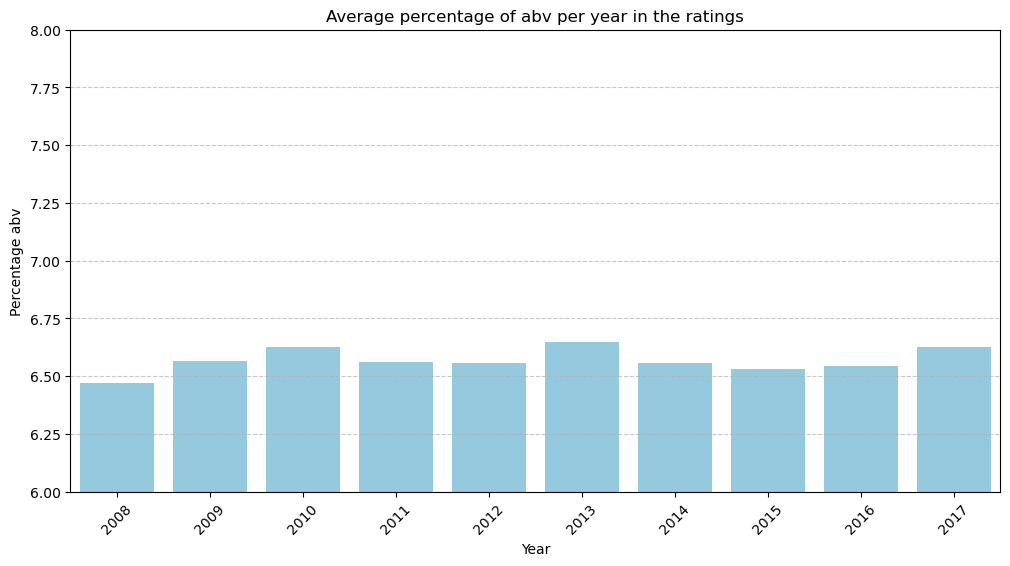

In [118]:
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=yearly_abv_df, x='year', y='abv', color='skyblue')

# Customize the plot
plt.title('Average percentage of abv per year in the ratings')
plt.xlabel('Year')
plt.ylabel('Percentage abv')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(6, 8)

# Display the plot
plt.show()

In [119]:
yearly_abv_df = final_merged_df.groupby(['year', 'macro_group'])['abv'].mean().reset_index()
print(yearly_abv_df)

    year macro_group       abv
0   2008         IPA  7.426801
1   2008       Other  6.390053
2   2009         IPA  7.569394
3   2009       Other  6.463539
4   2010         IPA  7.531379
5   2010       Other  6.518212
6   2011         IPA  7.436775
7   2011       Other  6.447584
8   2012         IPA  7.377356
9   2012       Other  6.431715
10  2013         IPA  7.299411
11  2013       Other  6.531332
12  2014         IPA  7.102182
13  2014       Other  6.447615
14  2015         IPA  6.923287
15  2015       Other  6.441550
16  2016         IPA  6.867828
17  2016       Other  6.463566
18  2017         IPA  6.885860
19  2017       Other  6.553452


C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_19660\799210993.py:4: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.barplot(data=yearly_abv_df, x='year', y='abv', hue='macro_group', color='skyblue')


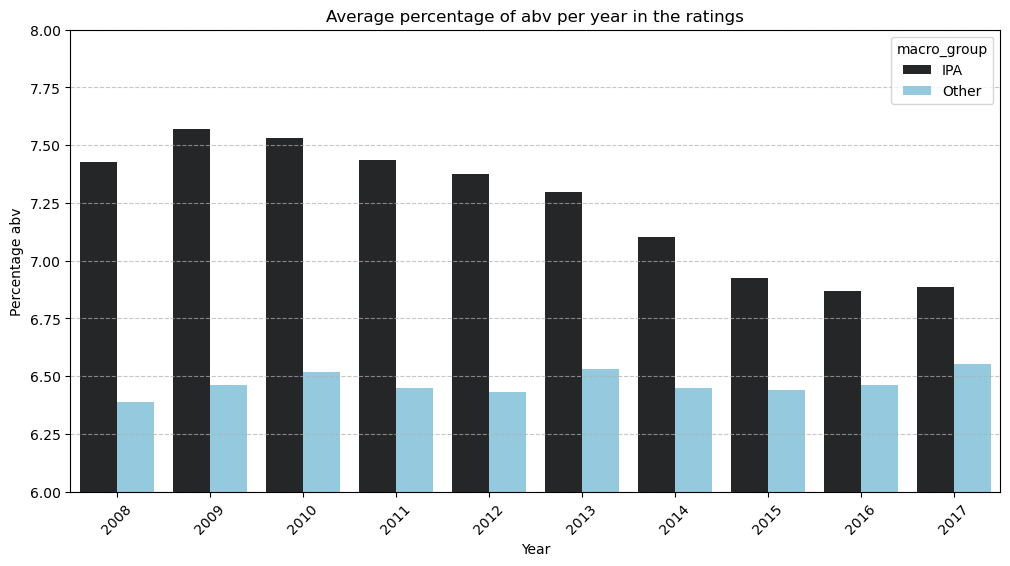

In [120]:
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=yearly_abv_df, x='year', y='abv', hue='macro_group', color='skyblue')

# Customize the plot
plt.title('Average percentage of abv per year in the ratings')
plt.xlabel('Year')
plt.ylabel('Percentage abv')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(6, 8)

# Display the plot
plt.show()

In [121]:
threshold = 4.5
final_merged_df['good_rating'] = final_merged_df['rating'] > threshold
abv_depend_ratings = final_merged_df.groupby(['good_rating', 'year'])['abv'].mean().reset_index().copy()
print(abv_depend_ratings)

    good_rating  year       abv
0         False  2008  6.452309
1         False  2009  6.545223
2         False  2010  6.604779
3         False  2011  6.541742
4         False  2012  6.533961
5         False  2013  6.622590
6         False  2014  6.535498
7         False  2015  6.510304
8         False  2016  6.527807
9         False  2017  6.606443
10         True  2008  8.309459
11         True  2009  8.753809
12         True  2010  8.515254
13         True  2011  8.409578
14         True  2012  8.193912
15         True  2013  8.357725
16         True  2014  8.315863
17         True  2015  8.249796
18         True  2016  8.263607
19         True  2017  8.420819


C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_19660\2686310085.py:4: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.barplot(data=abv_depend_ratings, x='year', y='abv', hue='good_rating', color='skyblue')


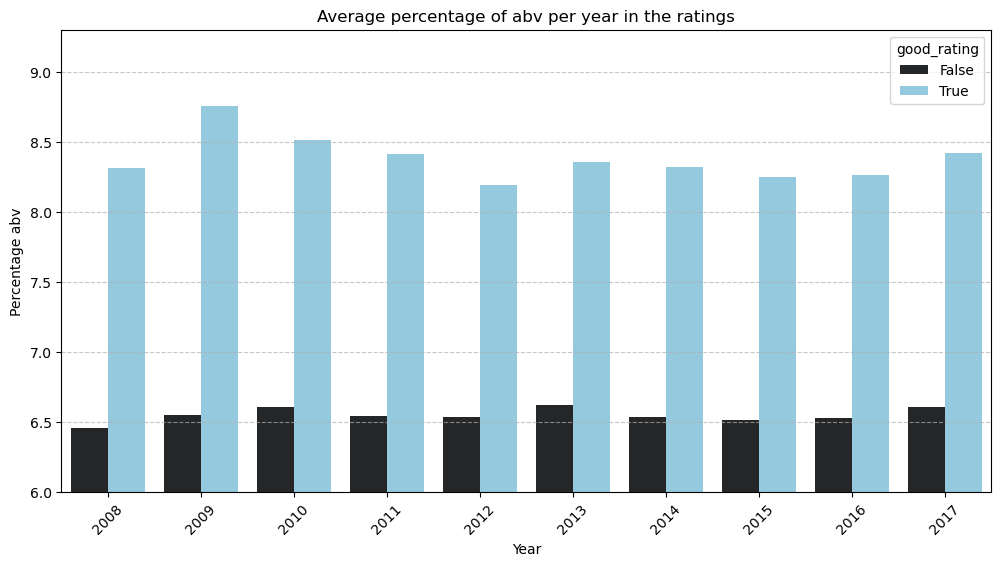

In [123]:
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(data=abv_depend_ratings, x='year', y='abv', hue='good_rating', color='skyblue')

# Customize the plot
plt.title('Average percentage of abv per year in the ratings')
plt.xlabel('Year')
plt.ylabel('Percentage abv')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(6, 9.3)

# Display the plot
plt.show()